# Exploration on public record

## Excutive Summary

### Goal

The information I am looking for is:

1. the distribution of each varaible

2. the linear/non-linear relationship between variable

Based on the quantitative analysis, I hope to get some understandings about the business and situation.

### Background


## Analysis

### Data
#### Public Records

There are 14 columns in this dataset. The descriptions for each columns are as follows:

Analytics Matchkey(analytics_matchkey): Unique customer identifier

Industry Code (Kind of Business, industry_code_kind_of_business): A code used to categorize subscribers by their primary line of business (e.g. A=Automotive, B=Banks and S&Ls).  The second position of the code further describes kind of business. 

Reporting Subscriber Code(reporting_subscriber_code): Internal trade line identifier.  The first 4 bytes are the base code, the last 3 bytes are the suffix.

Public Record Type Code(public_record_type_code): Identifies the type of public record.  

Effective Date (Date Verified, effective_date_date_verified): Date when the Reporting Subscriber took cognizance of the Record in its files.

Filed Date(filed_date): Date when the Record became officially public.

Paid Date(paid_date): Displays the date the subject paid the assessed amount.

Amount(amount): Displays the original amount in the case.

Public Record Source Type Code(public_record_source_type_code): Identifies the source (court) of this case information.  

Equal Credit Opportunity Act Code(equal_credit_opportunity_act_code): Displays the contractual ownership of the public record.  

Legislative Prohibited Code(legislative_prohibited_code): Identifies if the account is Medical related.   

Plaintiff Name: Plaintiff Name

Attorney Name: Attorney Name

Docket Number: Docket Number


#### Loan Performance

There are 5 columns in this dataset. The descriptions for each columns are as follows:

Analytics Matchkey: Unique customer identifier

Max Loan Amount: The amount of the loan given

Late 30 Days: Indicates if a loan was ever delinquent by at least 30 days in 24 months.

Late 60 Days: Indicates if a loan was ever delinquent by at least 60 days in 24 months.

Late 90 Days: Indicates if a loan was ever delinquent by at least 90 days in 24 months.

### Methdology

## Findings

### Final results

### Future works

### Recommendations

## Analysis Process

### Exploratory Data Analysis

According to the rudimentary exploration on the whole dataset:

1. 1 unique identifier for customer: there are 83586 repeated analytics_matchkey's, which means there are some customers who have more than 1 loan with our company.

2. 6 categorical columns:'industry_code_kind_of_business','reporting_subscriber_code', 'public_record_type_code', 'public_record_source_type_code', 'equal_credit_opportunity_act_code', 'legislative_prohibited_code'. I might not change the data types of these columns since this wouldn't affect my analysis. For 'public_record_type_code' I am going to bin together the classes whose sizes are too small(less than 30).

3. 1 numerical columns: 'amount'

4. 3 datetime columns: 'effective_date_date_verified','filed_date', 'paid_date'. I might consider binning these variables to make the trend more noticeable.

5. 3 columns 'plaintiff_name', 'attorney_name','docket_number' contain no information and these columns will be removed.

6. columns 'effective_date_date_verified', 'paid_date','amount','public_record_source_type_code' have missing data. Among these columns, there is only 1 missing value in 'public_record_source_type_code', it is very likely that this can be a typo. For the datetime columns, I will create binary variables indicating if a given loan went through a certain step(filed/paid/verified). For the missing value in 'public_record_source_type_code', I might just leave it there.

7. By now, about 60% of loans have paid the assessed amount.

8. More than 70% of loans have the information of the original amount in the case.

In [218]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
from numpy import mean
import scipy.stats as st
from datetime import date, timedelta
import statistics


import pdpbox
from pdpbox import pdp
from pdpbox.info_plots import target_plot
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
# from sklearn.metrics import accuracy_score 
# from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.tree.export import export_text
from sklearn.tree import plot_tree
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from matplotlib.pylab import rcParams


In [2]:
publicRecords = pd.read_csv('Public_records.csv',parse_dates=['effective_date_date_verified',
                                                    'filed_date',
                                                    'paid_date'])

In [3]:
loanPerformance = pd.read_csv('Loan_performance.csv')

In [4]:
loanPerformance.describe()

,analytics_matchkey,max_loan_amount,late_30_days,late_60_days,late_90_days
count,6.461270e+05,646127.000000,646127.000000,646127.000000,646127.000000
mean,1.669828e+06,1742.545930,0.121569,0.091559,0.081602
std,1.865318e+05,730.869254,0.326788,0.288403,0.273757
min,1.346745e+06,1000.000000,0.000000,0.000000,0.000000
25%,1.508286e+06,1166.000000,0.000000,0.000000,0.000000
50%,1.669831e+06,1500.000000,0.000000,0.000000,0.000000
75%,1.831370e+06,2076.000000,0.000000,0.000000,0.000000
max,1.992908e+06,4000.000000,1.000000,1.000000,1.000000


In [5]:
print(loanPerformance[loanPerformance['late_30_days']>0].shape[0]/646127)
print(loanPerformance[loanPerformance['late_60_days']>0].shape[0]/646127)
print(loanPerformance[loanPerformance['late_90_days']>0].shape[0]/646127)

0.12156897947307573
0.09155939931313813
0.08160160463809746


In [6]:
publicRecords.head()

,analytics_matchkey,industry_code_kind_of_business,reporting_subscriber_code,public_record_type_code,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number
0,1346747,ZP,99,CJ,2013-06-04,2013-01-29,NaT,1209.0,CI,I,1,NaN,NaN,NaN
1,1346748,ZP,485,7X,2014-09-25,2014-05-06,2014-09-24,NaN,FE,I,1,NaN,NaN,NaN
2,1346754,Z,11R,SL,2012-01-24,2011-04-05,NaT,2248.0,RD,I,1,NaN,NaN,NaN
3,1346754,ZP,1,7X,2013-01-29,2012-09-28,2013-01-28,NaN,FE,C,1,NaN,NaN,NaN
4,1346756,ZP,1,RL,2014-09-13,2007-02-02,2014-08-01,406.0,RD,I,1,NaN,NaN,NaN


In [7]:
publicRecords.describe().round()

,analytics_matchkey,amount,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number
count,218303.0,156792.0,218303.0,0.0,0.0,0.0
mean,1669627.0,4617.0,1.0,NaN,NaN,NaN
std,186294.0,41801.0,0.0,NaN,NaN,NaN
min,1346747.0,0.0,1.0,NaN,NaN,NaN
25%,1508168.0,644.0,1.0,NaN,NaN,NaN
50%,1669451.0,1338.0,1.0,NaN,NaN,NaN
75%,1831498.0,3174.0,1.0,NaN,NaN,NaN
max,1992902.0,9999999.0,2.0,NaN,NaN,NaN


In [8]:
publicRecords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218303 entries, 0 to 218302
Data columns (total 14 columns):
analytics_matchkey                   218303 non-null int64
industry_code_kind_of_business       218303 non-null object
reporting_subscriber_code            218303 non-null object
public_record_type_code              218303 non-null object
effective_date_date_verified         218018 non-null datetime64[ns]
filed_date                           218303 non-null datetime64[ns]
paid_date                            129421 non-null datetime64[ns]
amount                               156792 non-null float64
public_record_source_type_code       218302 non-null object
equal_credit_opportunity_act_code    218303 non-null object
legislative_prohibited_code          218303 non-null int64
plaintiff_name                       0 non-null float64
attorney_name                        0 non-null float64
docket_number                        0 non-null float64
dtypes: datetime64[ns](3), float64(4),

In [9]:
# check the proportion of loans have information of 'paid_date'(paid the assessed amount)
print(round(129421/218303,2),'of loans have paid the assessed amount.')
# check the proportion of loans have information of 'amount'(the original amount in the case)
print(round(156792/218303,2),'of loans have the information of the original amount in the case.')

0.59 of loans have paid the assessed amount.
0.72 of loans have the information of the original amount in the case.


In [10]:
# check whether 'analytics_matchkey' is unique==> looking for the key to identify each example
publicRecords.shape[0] - len(set(publicRecords['analytics_matchkey']))

83586

In [11]:
uni_test = pd.DataFrame(publicRecords.groupby(['analytics_matchkey','filed_date','amount'])['analytics_matchkey'].count())
uni_test[uni_test['analytics_matchkey']>1].shape[0]

438

In [12]:
publicRecords['ID'] = list(range(publicRecords.shape[0]))

In [13]:
# drop the columnns: 'plaintiff_name','attorney_name','docket_number'
publicRecords = publicRecords.drop(['plaintiff_name','attorney_name','docket_number'], axis=1)

In [14]:
# check the distribution of categorial variables:
# 'industry_code_kind_of_business'
# 'reporting_subscriber_code'           
# 'public_record_type_code'              


print(publicRecords['public_record_source_type_code'].value_counts())
print(publicRecords['equal_credit_opportunity_act_code'].value_counts())
print(publicRecords['legislative_prohibited_code'].value_counts())

ZP    198571
Z      19732
Name: industry_code_kind_of_business, dtype: int64
1      6075
203    2533
82     2502
3      2454
2      2356
       ... 
22H       1
23W       1
781       1
63G       1
942       1
Name: reporting_subscriber_code, Length: 1535, dtype: int64
CJ    61425
7X    49842
PC    30449
RL    20099
SL    16205
CB    10266
FT     6511
PL     6172
3D     4356
PF     3591
3X     3500
3F     2184
TL     1764
7D     1109
7F      487
CP      301
1D       14
1X       11
TB        9
2X        3
2F        2
2D        2
1F        1
Name: public_record_type_code, dtype: int64
CI    97445
FE    58896
RD    54657
MU     3291
BK     2611
SU      486
CC      219
CR      195
SC      163
DC      146
JU       53
CT       50
MA       42
CL       26
CY       11
CP        6
CA        2
PC        1
AS        1
CN        1
Name: public_record_source_type_code, dtype: int64
I    156027
C     62276
Name: equal_credit_opportunity_act_code, dtype: int64
1    202909
2     15394
Name: legislative_

In [16]:
publicRecords['amount'] = publicRecords['amount'].fillna(0)

### The distribution of each variable

In [57]:
publicRecords.columns

Index(['analytics_matchkey', 'industry_code_kind_of_business',
       'reporting_subscriber_code', 'public_record_type_code',
       'effective_date_date_verified', 'filed_date', 'paid_date', 'amount',
       'public_record_source_type_code', 'equal_credit_opportunity_act_code',
       'legislative_prohibited_code', 'ID', 'public_record_type_code_bin',
       'diff_paid_filed', 'diff_effe_paid', 'diff_paid_filed_int',
       'diff_effe_paid_int', 'diff_paid_filed_bin', 'diff_effe_paid_bin',
       'diff_effe_paid_label'],
      dtype='object')

#### industry_code_kind_of_business

According the analysis, I got the following findings:

1. Judging from the amount, count, there are much more cases in the industry of ZP in terms of quantity of cases or the total amount.

2. Judging from avg_amount_per_case	std_mean_ratio, the average amount per case in the industry of Z is larger than that of the other industry.

3. Juding from std_mean_ratio, the average amount per case in the industry of Z has much larger variance.

In [187]:
publicRecords.head()

,analytics_matchkey,industry_code_kind_of_business,reporting_subscriber_code,public_record_type_code,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,ID,public_record_type_code_bin,diff_paid_filed,diff_effe_paid,diff_paid_filed_int,diff_effe_paid_int,diff_paid_filed_bin,diff_effe_paid_bin,diff_effe_paid_label
0,1346747,ZP,99,CJ,2013-06-04,2013-01-29,NaT,1209.0,CI,I,1,0,CJ,NaT,NaT,99999.0,99999.0,NaN,NaN,Nan
1,1346748,ZP,485,7X,2014-09-25,2014-05-06,2014-09-24,0.0,FE,I,1,1,7X,141 days,1 days,141.0,1.0,"(119.0, 238.0]","(0.0, 50.0]","[-491,319]"
2,1346754,Z,11R,SL,2012-01-24,2011-04-05,NaT,2248.0,RD,I,1,2,SL,NaT,NaT,99999.0,99999.0,NaN,NaN,Nan
3,1346754,ZP,1,7X,2013-01-29,2012-09-28,2013-01-28,0.0,FE,C,1,3,7X,122 days,1 days,122.0,1.0,"(119.0, 238.0]","(0.0, 50.0]","[-491,319]"
4,1346756,ZP,1,RL,2014-09-13,2007-02-02,2014-08-01,406.0,RD,I,1,4,RL,2737 days,43 days,2737.0,43.0,"(950.0, 3794.0]","(0.0, 50.0]","[-491,319]"


In [198]:
ic_cnt = pd.DataFrame(publicRecords['industry_code_kind_of_business'].value_counts())
ic_cnt.columns = ['count']
ic_cnt['code'] = ic_cnt.index

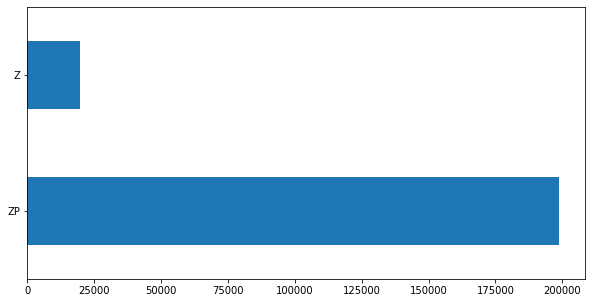

In [64]:
rcParams['figure.figsize'] = 10,5
publicRecords['industry_code_kind_of_business'].value_counts(dropna=False).plot(kind='barh')

In [216]:
ic_amt = pd.DataFrame(publicRecords.groupby('industry_code_kind_of_business')['amount'].sum())
ic_amt['code'] = ic_amt.index
ic_std = pd.DataFrame(publicRecords.groupby('industry_code_kind_of_business')['amount'].std())
ic_std.columns = ['std']
ic_std['code'] = ic_std.index
ic_temp = pd.merge(ic_cnt, ic_amt, on='code')
ic_temp = pd.merge(ic_temp, ic_std, on='code')
ic_temp['avg_amount_per_case'] = ic_temp['amount']/ic_temp['count']
ic_temp['std_mean_ratio'] = ic_temp['std']/ic_temp['avg_amount_per_case']
ic_temp.head()

,count,code,amount,std,avg_amount_per_case,std_mean_ratio
0,198571,ZP,621693829.0,28724.249336,3130.838990,9.174617
1,19732,Z,102162984.0,75001.835225,5177.528076,14.486032


#### reporting_subscriber_code

According the analysis, I got the following findings:

1. No matter we are looking at the reporting subscriber code from the perspective of the count or the total amount or the average amount, the distribution tend to be less normal:
    
    (1) Judging from the fact that means are much greater than median(50%)s, all are left-skewed.
    (2) Judging from the ratio between means and standard deviations, the variations are pretty large. The variance of avg_amount_per_case is the largest.

2. As for the trend of the count, the total amount and the average amount, to achieve higher total amount, for each line(reporting subscriber code), both the quantity of cases(count) and the average amount(avg_amount_per_case) contribute a lot. But the quantity of cases(count) has a larger effect, since the tops ordered by count have more large total amount's.

In [162]:
rsc_cnt_temp = pd.DataFrame(publicRecords['reporting_subscriber_code'].value_counts())
rsc_cnt_temp['count'] = rsc_cnt_temp['reporting_subscriber_code'] 
rsc_cnt_temp['code'] = rsc_cnt_temp.index
rsc_cnt_temp = rsc_cnt_temp[['code','count']]
rsc_cnt_temp.head()

,code,count
1,1,6075
203,203,2533
82,82,2502
3,3,2454
2,2,2356


In [181]:
rsc_amt_temp = pd.DataFrame(publicRecords.groupby('reporting_subscriber_code')['amount'].sum()).sort_values(
    by=['amount'],ascending = False)
rsc_amt_temp['code'] = rsc_amt_temp.index
rsc_amt_temp = rsc_amt_temp[['code','amount']]
rsc_temp = pd.merge(rsc_cnt_temp, rsc_amt_temp, on='code')
rsc_temp['avg_amount_per_case'] = rsc_temp['amount']/rsc_temp['count']
rsc_temp.describe()

,count,amount,avg_amount_per_case
count,1535.000000,1.535000e+03,1535.000000
mean,142.216938,4.715680e+05,6655.990429
std,314.763839,1.082067e+06,17635.637553
min,1.000000,0.000000e+00,0.000000
25%,6.000000,1.673250e+04,1736.968750
50%,31.000000,1.053360e+05,3015.268293
75%,151.000000,4.531315e+05,5642.041667
max,6075.000000,1.785021e+07,512303.000000


In [186]:
rsc_temp.std()/rsc_temp.mean()

count                  2.213265
amount                 2.294616
avg_amount_per_case    2.649589
dtype: float64

In [178]:
rsc_temp = rsc_temp.sort_values(by = 'count',ascending = False)
rsc_temp['count_order'] = list(range(rsc_temp.shape[0]))
rsc_temp.head()

,code,count,amount,avg_amount_per_case,count_order
0,1,6075,9338789.0,1537.249218,0
1,203,2533,125464.0,49.531780,1
2,82,2502,2138978.0,854.907274,2
3,3,2454,4285216.0,1746.216789,3
4,2,2356,3195255.0,1356.220289,4


In [179]:
rsc_temp = rsc_temp.sort_values(by = 'amount',ascending = False)
rsc_temp['amount_order'] = list(range(rsc_temp.shape[0]))
rsc_temp.head()

,code,count,amount,avg_amount_per_case,count_order,amount_order
14,25N,1566,17850212.0,11398.602810,14,0
60,11J,692,14507249.0,20964.232659,60,1
413,141,133,10488896.0,78863.879699,415,2
0,1,6075,9338789.0,1537.249218,0,3
82,25R,587,8855615.0,15086.226576,82,4


In [180]:
rsc_temp = rsc_temp.sort_values(by = 'avg_amount_per_case',ascending = False)
rsc_temp['avg_amount_order'] = list(range(rsc_temp.shape[0]))
rsc_temp.head()

,code,count,amount,avg_amount_per_case,count_order,amount_order,avg_amount_order
1498,34N,1,512303.0,512303.000000,1408,358,0
1223,13U,4,671275.0,167818.750000,1241,293,1
1508,02L,1,153974.0,153974.000000,1452,671,2
1012,847,11,1630722.0,148247.454545,998,112,3
1236,09K,4,418780.0,104695.000000,1214,407,4


#### public_record_type_code


In [226]:
publicRecords['public_record_type_code'].value_counts()

CJ    61425
7X    49842
PC    30449
RL    20099
SL    16205
CB    10266
FT     6511
PL     6172
3D     4356
PF     3591
3X     3500
3F     2184
TL     1764
7D     1109
7F      487
CP      301
1D       14
1X       11
TB        9
2X        3
2F        2
2D        2
1F        1
Name: public_record_type_code, dtype: int64

In [227]:
# bin public_record_type_code: If there are less than 30 examples in a class
to_replace_rsc = pd.DataFrame(publicRecords['public_record_type_code'].value_counts())
to_replace_rs_list = to_replace_rsc[to_replace_rsc['public_record_type_code']<30].index.to_list()
def rep_PRTC(x):
    if x in to_replace_rs_list:
        return 'other'
    else: return x
publicRecords['public_record_type_code_bin'] = publicRecords['public_record_type_code'].map(rep_PRTC)

In [228]:
publicRecords['public_record_type_code_bin'].value_counts()

CJ       61425
7X       49842
PC       30449
RL       20099
SL       16205
CB       10266
FT        6511
PL        6172
3D        4356
PF        3591
3X        3500
3F        2184
TL        1764
7D        1109
7F         487
CP         301
other       42
Name: public_record_type_code_bin, dtype: int64

In [229]:
prtc_cnt = pd.DataFrame(publicRecords['public_record_type_code'].value_counts())
prtc_cnt.columns = ['count']
prtc_cnt['code'] = prtc_cnt.index

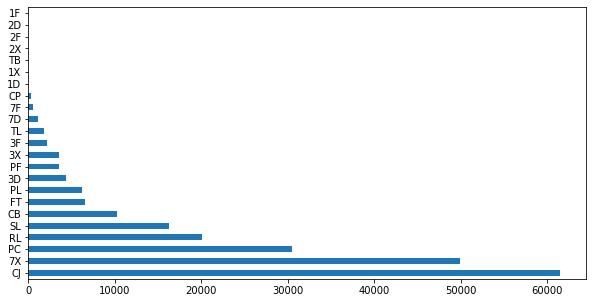

In [230]:
rcParams['figure.figsize'] = 10,5
publicRecords['public_record_type_code'].value_counts(dropna=False).plot(kind='barh')

In [236]:
prtc_amt = pd.DataFrame(publicRecords.groupby('public_record_type_code')['amount'].sum())
prtc_amt['code'] = prtc_amt.index
prtc_std = pd.DataFrame(publicRecords.groupby('public_record_type_code')['amount'].std())
prtc_std.columns = ['std']
prtc_std['code'] = prtc_std.index
prtc_temp = pd.merge(prtc_cnt, prtc_amt, on='code')
prtc_temp = pd.merge(prtc_temp, prtc_std, on='code')
prtc_temp['avg_amount_per_case'] = prtc_temp['amount']/prtc_temp['count']
prtc_temp['std_mean_ratio'] = prtc_temp['std']/prtc_temp['avg_amount_per_case']

In [250]:
publicRecords.groupby('public_record_type_code')['amount'].min()

public_record_type_code
1D      0.0
1F      0.0
1X      0.0
2D      0.0
2F      0.0
2X      0.0
3D      0.0
3F      0.0
3X      0.0
7D      0.0
7F      0.0
7X      0.0
CB     50.0
CJ     50.0
CP      0.0
FT     62.0
PC      0.0
PF     72.0
PL      0.0
RL      0.0
SL      0.0
TB    427.0
TL     50.0
Name: amount, dtype: float64

In [235]:
print(list(prtc_temp[prtc_temp['amount']==0]['code']),"have 0 in amount")

['7X', '3D', '3X', '3F', '7D', '7F', '1D', '1X', '2X', '2F', '2D', '1F'] have 0 in amount


In [247]:
prtc_temp = prtc_temp[prtc_temp['amount']>0]
prtc_temp = prtc_temp.sort_values(by='count',ascending = False)
prtc_temp['count_order'] = list(range(prtc_temp.shape[0]))
prtc_temp = prtc_temp.sort_values(by='amount',ascending = False)
prtc_temp['amount_order'] = list(range(prtc_temp.shape[0]))
prtc_temp = prtc_temp.sort_values(by='avg_amount_per_case',ascending = False)
prtc_temp['avg_amt_order'] = list(range(prtc_temp.shape[0]))
prtc_temp

,count,code,amount,std,avg_amount_per_case,std_mean_ratio,count_order,amount_order,avg_amt_order
6,6511,FT,216195113.0,65710.576177,33204.594225,1.978960,5,0,0
9,3591,PF,86151990.0,177584.219704,23991.086048,7.402092,7,2,1
18,9,TB,105649.0,26531.793441,11738.777778,2.260184,10,10,2
15,301,CP,2321949.0,10927.246044,7714.116279,1.416526,9,8,3
5,10266,CB,53847607.0,17950.356195,5245.237386,3.422220,4,4,4
4,16205,SL,52464192.0,9366.738116,3237.531132,2.893173,3,5,5
0,61425,CJ,193908558.0,12721.582701,3156.834481,4.029854,0,1,6
3,20099,RL,51900341.0,73261.143342,2582.234987,28.371215,2,6,7
7,6172,PL,11375439.0,13305.958852,1843.071776,7.219447,6,7,8
2,30449,PC,54570416.0,7517.410171,1792.190745,4.194537,1,3,9


According the analysis, I got the following findings:

1. The cases whose public_record_type_code is in the following list have 0 in amount: '7X', '3D', '3X', '3F', '7D', '7F', '1D', '1X', '2X', '2F', '2D', '1F'. If the public_record_type_code of the case is not in the list, it is still possible the amount of the case is 0.

2.

#### Hypothesis 1: The working process: filed_date => paid_date => effective_date_date_verified? 

Based on the distribution of difference between paid_date, filed_date and effective_date_date_verified, I have the following findings:

1. Mostly(more than 93%), the whole process is that the loan is firstly get filed, then paid(if needed), then verified. The first step must be filing. Very rarely, verification happens before the corresponding payment. 

2. The time interval between filed date and paid date(if there is) tends to be around 1 year and it varies a lot. It took 60-119 days for more than 35% of loans to be paid after it was filed. More than 30% of loans took 119-475 days. More than 12% of loans took 475-950 days. More than 10% of loans took 950-1900 days. 

2. The time interval between paid date(if there is) and effective date tends to less than 50 days, including the situation that effective date happens before its payment, and 50% of loans only took 0-4 days to be verified after it was paid. The range of this intervel is from -2355 days to 3202 days. 

In [17]:
# sub-hypothesis:
# filed_date is always earlier than paid_date, if there is a paid_date for the given loan
n_paid_date = publicRecords[~publicRecords['paid_date'].isna()].shape[0]
n_filed_date = publicRecords[~publicRecords['filed_date'].isna()].shape[0]
print(round(sum(publicRecords['filed_date']<publicRecords['paid_date'])/n_paid_date,4),'of the records with a paid_date, the filed_date happens before paid_date.')
print(round(sum(publicRecords['filed_date']==publicRecords['paid_date'])/n_paid_date,4),'of the records with a paid_date, the filed_date happen on the same day as paid_date.')
print(round(sum(publicRecords['filed_date']>publicRecords['paid_date'])/n_paid_date,4),'of the records with a paid_date, the filed_date happens after paid_date.')

0.9972 of the records with a paid_date, the filed_date happens before paid_date.
0.0028 of the records with a paid_date, the filed_date happen on the same day as paid_date.
0.0 of the records with a paid_date, the filed_date happens after paid_date.


In [18]:
# sub-hypothesis:
# paid_date is always earlier than effective_date_date_verified, if there is a paid_date for the given loan
print(round(sum(publicRecords['paid_date']<publicRecords['effective_date_date_verified'])/n_paid_date,4),'of the records with a paid_date, the paid_date happens before effective_date_date_verified.')
print(round(sum(publicRecords['paid_date']==publicRecords['effective_date_date_verified'])/n_paid_date,4),'of the records with a paid_date, the paid_date happens on the same day as effective_date_date_verified.')
print(round(sum(publicRecords['paid_date']>publicRecords['effective_date_date_verified'])/n_paid_date,4),'of the records with a paid_date, the paid_date happens after effective_date_date_verified.')

0.9313 of the records with a paid_date, the paid_date happens before effective_date_date_verified.
0.0004 of the records with a paid_date, the paid_date happens on the same day as effective_date_date_verified.
0.0681 of the records with a paid_date, the paid_date happens after effective_date_date_verified.


In [19]:
# sub-hypothesis:
# filed_date is always earlier than effective_date_date_verified, if there is a filed_date for the given loan
print(round(sum(publicRecords['filed_date']<publicRecords['effective_date_date_verified'])/n_filed_date ,4),'of the records with a filed_date , the filed_date happens before effective_date_date_verified.')
print(round(sum(publicRecords['filed_date']==publicRecords['effective_date_date_verified'])/n_filed_date ,4),'of the records with a filed_date, the filed_date happens on the same day as effective_date_date_verified.')
print(round(sum(publicRecords['filed_date']>publicRecords['effective_date_date_verified'])/n_filed_date ,4),'of the records with a filed_date, the filed_date happens after effective_date_date_verified.')

0.9951 of the records with a filed_date , the filed_date happens before effective_date_date_verified.
0.0036 of the records with a filed_date, the filed_date happens on the same day as effective_date_date_verified.
0.0 of the records with a filed_date, the filed_date happens after effective_date_date_verified.


In [20]:
publicRecords['diff_paid_filed'] = publicRecords['paid_date']-publicRecords['filed_date']
publicRecords['diff_effe_paid'] = publicRecords['effective_date_date_verified']-publicRecords['paid_date']

In [21]:
publicRecords['diff_paid_filed_int'] = publicRecords['diff_paid_filed']/np.timedelta64(1, 'D')
publicRecords['diff_effe_paid_int'] = publicRecords['diff_effe_paid']/np.timedelta64(1, 'D')
print(publicRecords['diff_paid_filed_int'].describe())
print(publicRecords['diff_effe_paid_int'].describe())

count    129421.000000
mean        380.077623
std         484.184294
min           0.000000
25%         100.000000
50%         139.000000
75%         461.000000
max        3793.000000
Name: diff_paid_filed_int, dtype: float64
count    129407.000000
mean         75.911774
std         358.554891
min       -2354.000000
25%           1.000000
50%           4.000000
75%          49.000000
max        3203.000000
Name: diff_effe_paid_int, dtype: float64


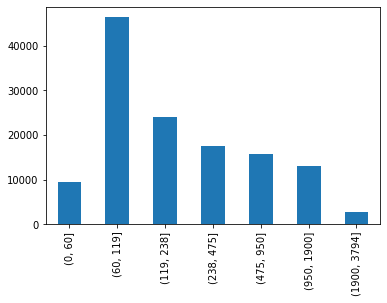

In [22]:
pd.cut(publicRecords[~publicRecords['diff_paid_filed_int'].isna()]['diff_paid_filed_int'], 
       bins=[0,60,119,238,475,950,1900,3794]).value_counts().sort_index().plot(kind='bar')

In [23]:
pd.cut(publicRecords[~publicRecords['diff_paid_filed_int'].isna()]['diff_paid_filed_int'], 
       bins=[0,60,119,238,475,950,1900,3794]).value_counts()/n_paid_date

(60, 119]       0.358033
(119, 238]      0.185889
(238, 475]      0.135589
(475, 950]      0.121734
(950, 1900]     0.100926
(0, 60]         0.073620
(1900, 3794]    0.021418
Name: diff_paid_filed_int, dtype: float64

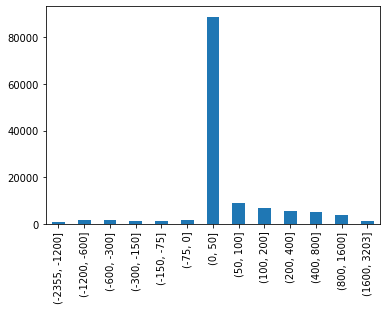

In [24]:
pd.cut(publicRecords[~publicRecords['diff_effe_paid_int'].isna()]['diff_effe_paid_int'], 
       bins=[-2355,-1200,-600,-300,-150,-75,0,50,100,200,400,800,1600,3203]).value_counts().sort_index().plot(kind='bar')

In [25]:
pd.cut(publicRecords[~publicRecords['diff_effe_paid_int'].isna()]['diff_effe_paid_int'], 
       bins=[-2355,-1200,-600,-300,-150,-75,0,50,100,200,400,800,1600,3203]).value_counts()/n_paid_date

(0, 50]           0.685638
(50, 100]         0.069131
(100, 200]        0.053593
(200, 400]        0.043733
(400, 800]        0.038665
(800, 1600]       0.029632
(-1200, -600]     0.014070
(-600, -300]      0.013661
(-75, 0]          0.012826
(-300, -150]      0.011142
(1600, 3203]      0.010941
(-150, -75]       0.010052
(-2355, -1200]    0.006807
Name: diff_effe_paid_int, dtype: float64

In [26]:
publicRecords[publicRecords['diff_effe_paid_int']<366]['diff_effe_paid_int'].count()/n_paid_date

0.9153151343290502

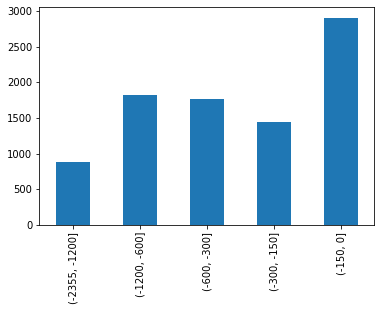

In [27]:
pd.cut(publicRecords[publicRecords['diff_effe_paid_int']<0]['diff_effe_paid_int'], 
       bins=[-2355,-1200,-600,-300,-150,0]).value_counts().sort_index().plot(kind='bar')

In [28]:
publicRecords['diff_paid_filed_bin'] = pd.cut(publicRecords['diff_paid_filed_int'], 
       bins=[0,60,119,238,475,950,3794])
publicRecords['diff_effe_paid_bin'] = pd.cut(publicRecords['diff_effe_paid_int'], 
       bins=[-2355,0,50,100,200,400,800,3203])

In [29]:
publicRecords.head(5)

,analytics_matchkey,industry_code_kind_of_business,reporting_subscriber_code,public_record_type_code,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,ID,public_record_type_code_bin,diff_paid_filed,diff_effe_paid,diff_paid_filed_int,diff_effe_paid_int,diff_paid_filed_bin,diff_effe_paid_bin
0,1346747,ZP,99,CJ,2013-06-04,2013-01-29,NaT,1209.0,CI,I,1,0,CJ,NaT,NaT,NaN,NaN,NaN,NaN
1,1346748,ZP,485,7X,2014-09-25,2014-05-06,2014-09-24,0.0,FE,I,1,1,7X,141 days,1 days,141.0,1.0,"(119.0, 238.0]","(0.0, 50.0]"
2,1346754,Z,11R,SL,2012-01-24,2011-04-05,NaT,2248.0,RD,I,1,2,SL,NaT,NaT,NaN,NaN,NaN,NaN
3,1346754,ZP,1,7X,2013-01-29,2012-09-28,2013-01-28,0.0,FE,C,1,3,7X,122 days,1 days,122.0,1.0,"(119.0, 238.0]","(0.0, 50.0]"
4,1346756,ZP,1,RL,2014-09-13,2007-02-02,2014-08-01,406.0,RD,I,1,4,RL,2737 days,43 days,2737.0,43.0,"(950.0, 3794.0]","(0.0, 50.0]"


In [30]:
def find_k(X):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X.reshape(-1,1))
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

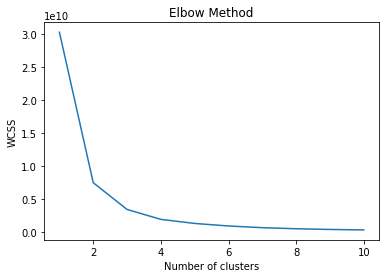

In [31]:
m_p_f = publicRecords[~publicRecords['diff_paid_filed_int'].isna()]
m_p_f_n = publicRecords[publicRecords['diff_paid_filed_int'].isna()]
x_p_f = m_p_f['diff_paid_filed_int'].values
find_k(x_p_f)

In [32]:
kmeans_p_f = KMeans(n_clusters=3)
kmeans_p_f.fit(x_p_f.reshape(-1,1))
labels_p_f = kmeans_p_f.predict(x_p_f.reshape(-1,1))

In [33]:
m_p_f['diff_paid_filed_label'] = labels_p_f
print(m_p_f.groupby('diff_paid_filed_label')['diff_paid_filed_int'].min())
print(m_p_f.groupby('diff_paid_filed_label')['diff_paid_filed_int'].max())
print(m_p_f.groupby('diff_paid_filed_label')['diff_paid_filed_int'].count()/n_paid_date)

diff_paid_filed_label
0       0.0
1    1272.0
2     476.0
Name: diff_paid_filed_int, dtype: float64
diff_paid_filed_label
0     475.0
1    3793.0
2    1271.0
Name: diff_paid_filed_int, dtype: float64
diff_paid_filed_label
0    0.755921
1    0.074269
2    0.169810
Name: diff_paid_filed_int, dtype: float64


In [34]:
m_p_f['diff_paid_filed_label'] = m_p_f['diff_paid_filed_label'].replace(
    0,'[0,474]').replace(1,'[1271,3793]').replace(2,'[475,1270]')
m_p_f_n['diff_paid_filed_label'] = 'Nan'
m_p_f_bind = pd.concat([m_p_f, m_p_f_n])
m_p_f_bind = m_p_f_bind.sort_values(by=['ID'])

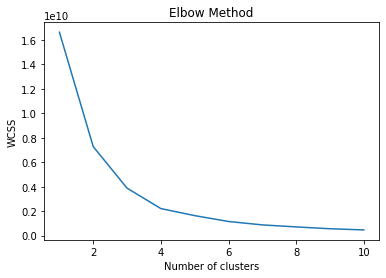

In [35]:
m_e_p = publicRecords[~publicRecords['diff_effe_paid_int'].isna()]
m_e_p_n = publicRecords[publicRecords['diff_effe_paid_int'].isna()]
x_e_p = m_e_p['diff_effe_paid_int'].values
find_k(x_e_p)

In [36]:
kmeans_e_p = KMeans(n_clusters=4)
kmeans_e_p.fit(x_e_p.reshape(-1,1))
labels_e_p = kmeans_e_p.predict(x_e_p.reshape(-1,1))
m_e_p['diff_effe_paid_label'] = labels_e_p
print(m_e_p.groupby('diff_effe_paid_label')['diff_effe_paid_int'].min())
print(m_e_p.groupby('diff_effe_paid_label')['diff_effe_paid_int'].max())
print(m_e_p.groupby('diff_effe_paid_label')['diff_effe_paid_int'].count()/n_paid_date)

diff_effe_paid_label
0    -491.0
1    1129.0
2   -2354.0
3     320.0
Name: diff_effe_paid_int, dtype: float64
diff_effe_paid_label
0     319.0
1    3203.0
2    -492.0
3    1127.0
Name: diff_effe_paid_int, dtype: float64
diff_effe_paid_label
0    0.882052
1    0.024440
2    0.024818
3    0.068582
Name: diff_effe_paid_int, dtype: float64


In [37]:
m_e_p['diff_effe_paid_label'] = m_e_p['diff_effe_paid_label'].replace(
    2,'[-2354,-492]').replace(3,'[320,1127]').replace(0,'[-491,319]').replace(1,'[1129,3203]')
m_e_p_n['diff_effe_paid_label'] = 'Nan'
m_e_p_bind = pd.concat([m_e_p, m_e_p_n])
m_e_p_bind = m_e_p_bind.sort_values(by=['ID'])

In [38]:
publicRecords = publicRecords.sort_values(by=['ID'])
publicRecords['diff_effe_paid_label'] = m_e_p_bind['diff_effe_paid_label']
m_p_f_bind_s = m_p_f_bind[['ID','diff_paid_filed_label']]
publicRecords_1 = pd.merge(publicRecords, m_p_f_bind_s, on='ID')

In [39]:
all(m_e_p_bind.groupby('ID')['ID'].count().values==1)

True

In [40]:
all(m_p_f_bind.groupby('ID')['ID'].count().values==1)

True

In [41]:
publicRecords['diff_paid_filed_int'] = publicRecords['diff_paid_filed_int'].fillna(99999)
publicRecords['diff_effe_paid_int'] = publicRecords['diff_effe_paid_int'].fillna(99999)

In [42]:
publicRecords.columns

Index(['analytics_matchkey', 'industry_code_kind_of_business',
       'reporting_subscriber_code', 'public_record_type_code',
       'effective_date_date_verified', 'filed_date', 'paid_date', 'amount',
       'public_record_source_type_code', 'equal_credit_opportunity_act_code',
       'legislative_prohibited_code', 'ID', 'public_record_type_code_bin',
       'diff_paid_filed', 'diff_effe_paid', 'diff_paid_filed_int',
       'diff_effe_paid_int', 'diff_paid_filed_bin', 'diff_effe_paid_bin',
       'diff_effe_paid_label'],
      dtype='object')

#### Hypothesis 2: Whether the data set can be segmented according to one column?

I am going to use decision tree method:

1. Judging from F-1 score to see whether it is possible to segment the dataset over one variable? The best segementing variable should have the highest F-1.

2. Also, the variables with high feature importance may have high correlationship with the segmenting variable.

In [43]:
dt = pd.get_dummies(publicRecords, prefix_sep="_",columns=['industry_code_kind_of_business',
                                                           'reporting_subscriber_code',
                                                           'public_record_type_code_bin',
                                                           'public_record_source_type_code',
                                                          'equal_credit_opportunity_act_code',
                                                          'legislative_prohibited_code',
#                                                            'diff_paid_filed_bin', 
#                                                            # same as 'diff_paid_filed_label', different way to bin
#                                                            'diff_effe_paid_bin',
#                                                            # same as 'diff_effe_paid_label', different way to bin
#                                                            'diff_effe_paid_label', 
#                                                            # same as 'diff_effe_paid_bin', different way to bin
#                                                            'diff_paid_filed_label'
#                                                           # same as 'diff_paid_filed_bin', different way to bin
                                                          ],drop_first = True)

In [44]:
targets = ['industry_code_kind_of_business','reporting_subscriber_code',
           'public_record_type_code_bin','public_record_source_type_code',
           'equal_credit_opportunity_act_code','legislative_prohibited_code']
drops = ['ID','analytics_matchkey','public_record_type_code','diff_paid_filed', 
         'diff_effe_paid', 'diff_paid_filed_bin', 'diff_effe_paid_bin',
       'diff_effe_paid_label', 'diff_paid_filed_label','effective_date_date_verified', 
         'filed_date', 'paid_date']
add = publicRecords[['ID']+targets]
dt1 = pd.merge(dt, add, on='ID')

In [45]:
publicRecords[publicRecords['public_record_source_type_code'].isna()]['public_record_source_type_code']

50691    NaN
Name: public_record_source_type_code, dtype: object

In [46]:
print(dt.shape)
print(add.shape)
print(dt1.shape)

(218303, 1586)
(218303, 7)
(218303, 1592)


In [47]:
cm_list = []
f1_list = []
m_list = []
X_list = []
for var in targets:
    print(var)
    X=dt1.loc[~dt1[var].isna(), ~dt1.columns.isin(targets+drops+list(dt.columns[pd.Series(dt.columns).str.startswith(var)].values))]
    Y=dt1.loc[~dt1[var].isna(),var]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1) 
    clf_gini = DecisionTreeClassifier(criterion = "gini", 
                random_state = 1,max_depth=3, min_samples_leaf=5)
    clf_gini.fit(X_train, y_train)
    m_list.append(clf_gini)
    X_list.append(list(X.columns))
    y_pred = clf_gini.predict(X_test)
    cm_list.append(confusion_matrix(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred, average='weighted'))

industry_code_kind_of_business
reporting_subscriber_code
public_record_type_code_bin
public_record_source_type_code
equal_credit_opportunity_act_code
legislative_prohibited_code


In [48]:
cm_list[0]

array([[  424,  5459],
       [   49, 59559]])

In [49]:
pd.DataFrame([targets,f1_list])

,0,1,2,3,4,5
0,industry_code_kind_of_business,reporting_subscriber_code,public_record_type_code_bin,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code
1,0.881929,0.00560798,0.787529,0.911473,0.593863,0.897061


In [50]:
for j in range(len(f1_list)):
    feature_name = X_list[j]
    f_imp = pd.DataFrame(m_list[j].feature_importances_)
    f_imp.columns = ['importance']
    f_imp['feature'] = feature_name
    print("---------",targets[j],"---------")
    print(f_imp[f_imp['importance']>0].sort_values(by = ['importance'], ascending = False))

--------- industry_code_kind_of_business ---------
      importance                            feature
0       0.427192                             amount
141     0.310127      reporting_subscriber_code_11J
1466    0.255261       reporting_subscriber_code_92
1127    0.006900      reporting_subscriber_code_594
1569    0.000520  public_record_source_type_code_RD
--------- reporting_subscriber_code ---------
    importance                            feature
0     0.360115                             amount
23    0.270132  public_record_source_type_code_CI
36    0.114945  public_record_source_type_code_RD
11    0.112812     public_record_type_code_bin_CP
3     0.078084  industry_code_kind_of_business_ZP
2     0.063912                 diff_effe_paid_int
--------- public_record_type_code_bin ---------
      importance                            feature
1        0.34867                diff_paid_filed_int
1554     0.33363  public_record_source_type_code_RD
0        0.31770                     

[Text(2480.0, 2378.25, 'amount <= 46.0\ngini = 0.165\nsamples = 152812\nvalue = [13849, 138963]'),
 Text(1488.0, 1698.75, 'reporting_subscriber_code_594 <= 0.5\ngini = 0.001\nsamples = 43476\nvalue = [16, 43460]'),
 Text(992.0, 1019.25, 'public_record_source_type_code_RD <= 0.5\ngini = 0.0\nsamples = 43468\nvalue = [8, 43460]'),
 Text(496.0, 339.75, 'gini = 0.0\nsamples = 43362\nvalue = [0, 43362]'),
 Text(1488.0, 339.75, 'gini = 0.14\nsamples = 106\nvalue = [8, 98]'),
 Text(1984.0, 1019.25, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(3472.0, 1698.75, 'reporting_subscriber_code_11J <= 0.5\ngini = 0.221\nsamples = 109336\nvalue = [13833, 95503]'),
 Text(2976.0, 1019.25, 'reporting_subscriber_code_92 <= 0.5\ngini = 0.215\nsamples = 108867\nvalue = [13364, 95503]'),
 Text(2480.0, 339.75, 'gini = 0.209\nsamples = 108230\nvalue = [12853, 95377]'),
 Text(3472.0, 339.75, 'gini = 0.317\nsamples = 637\nvalue = [511, 126]'),
 Text(3968.0, 1019.25, 'gini = 0.0\nsamples = 469\nvalue = [469, 

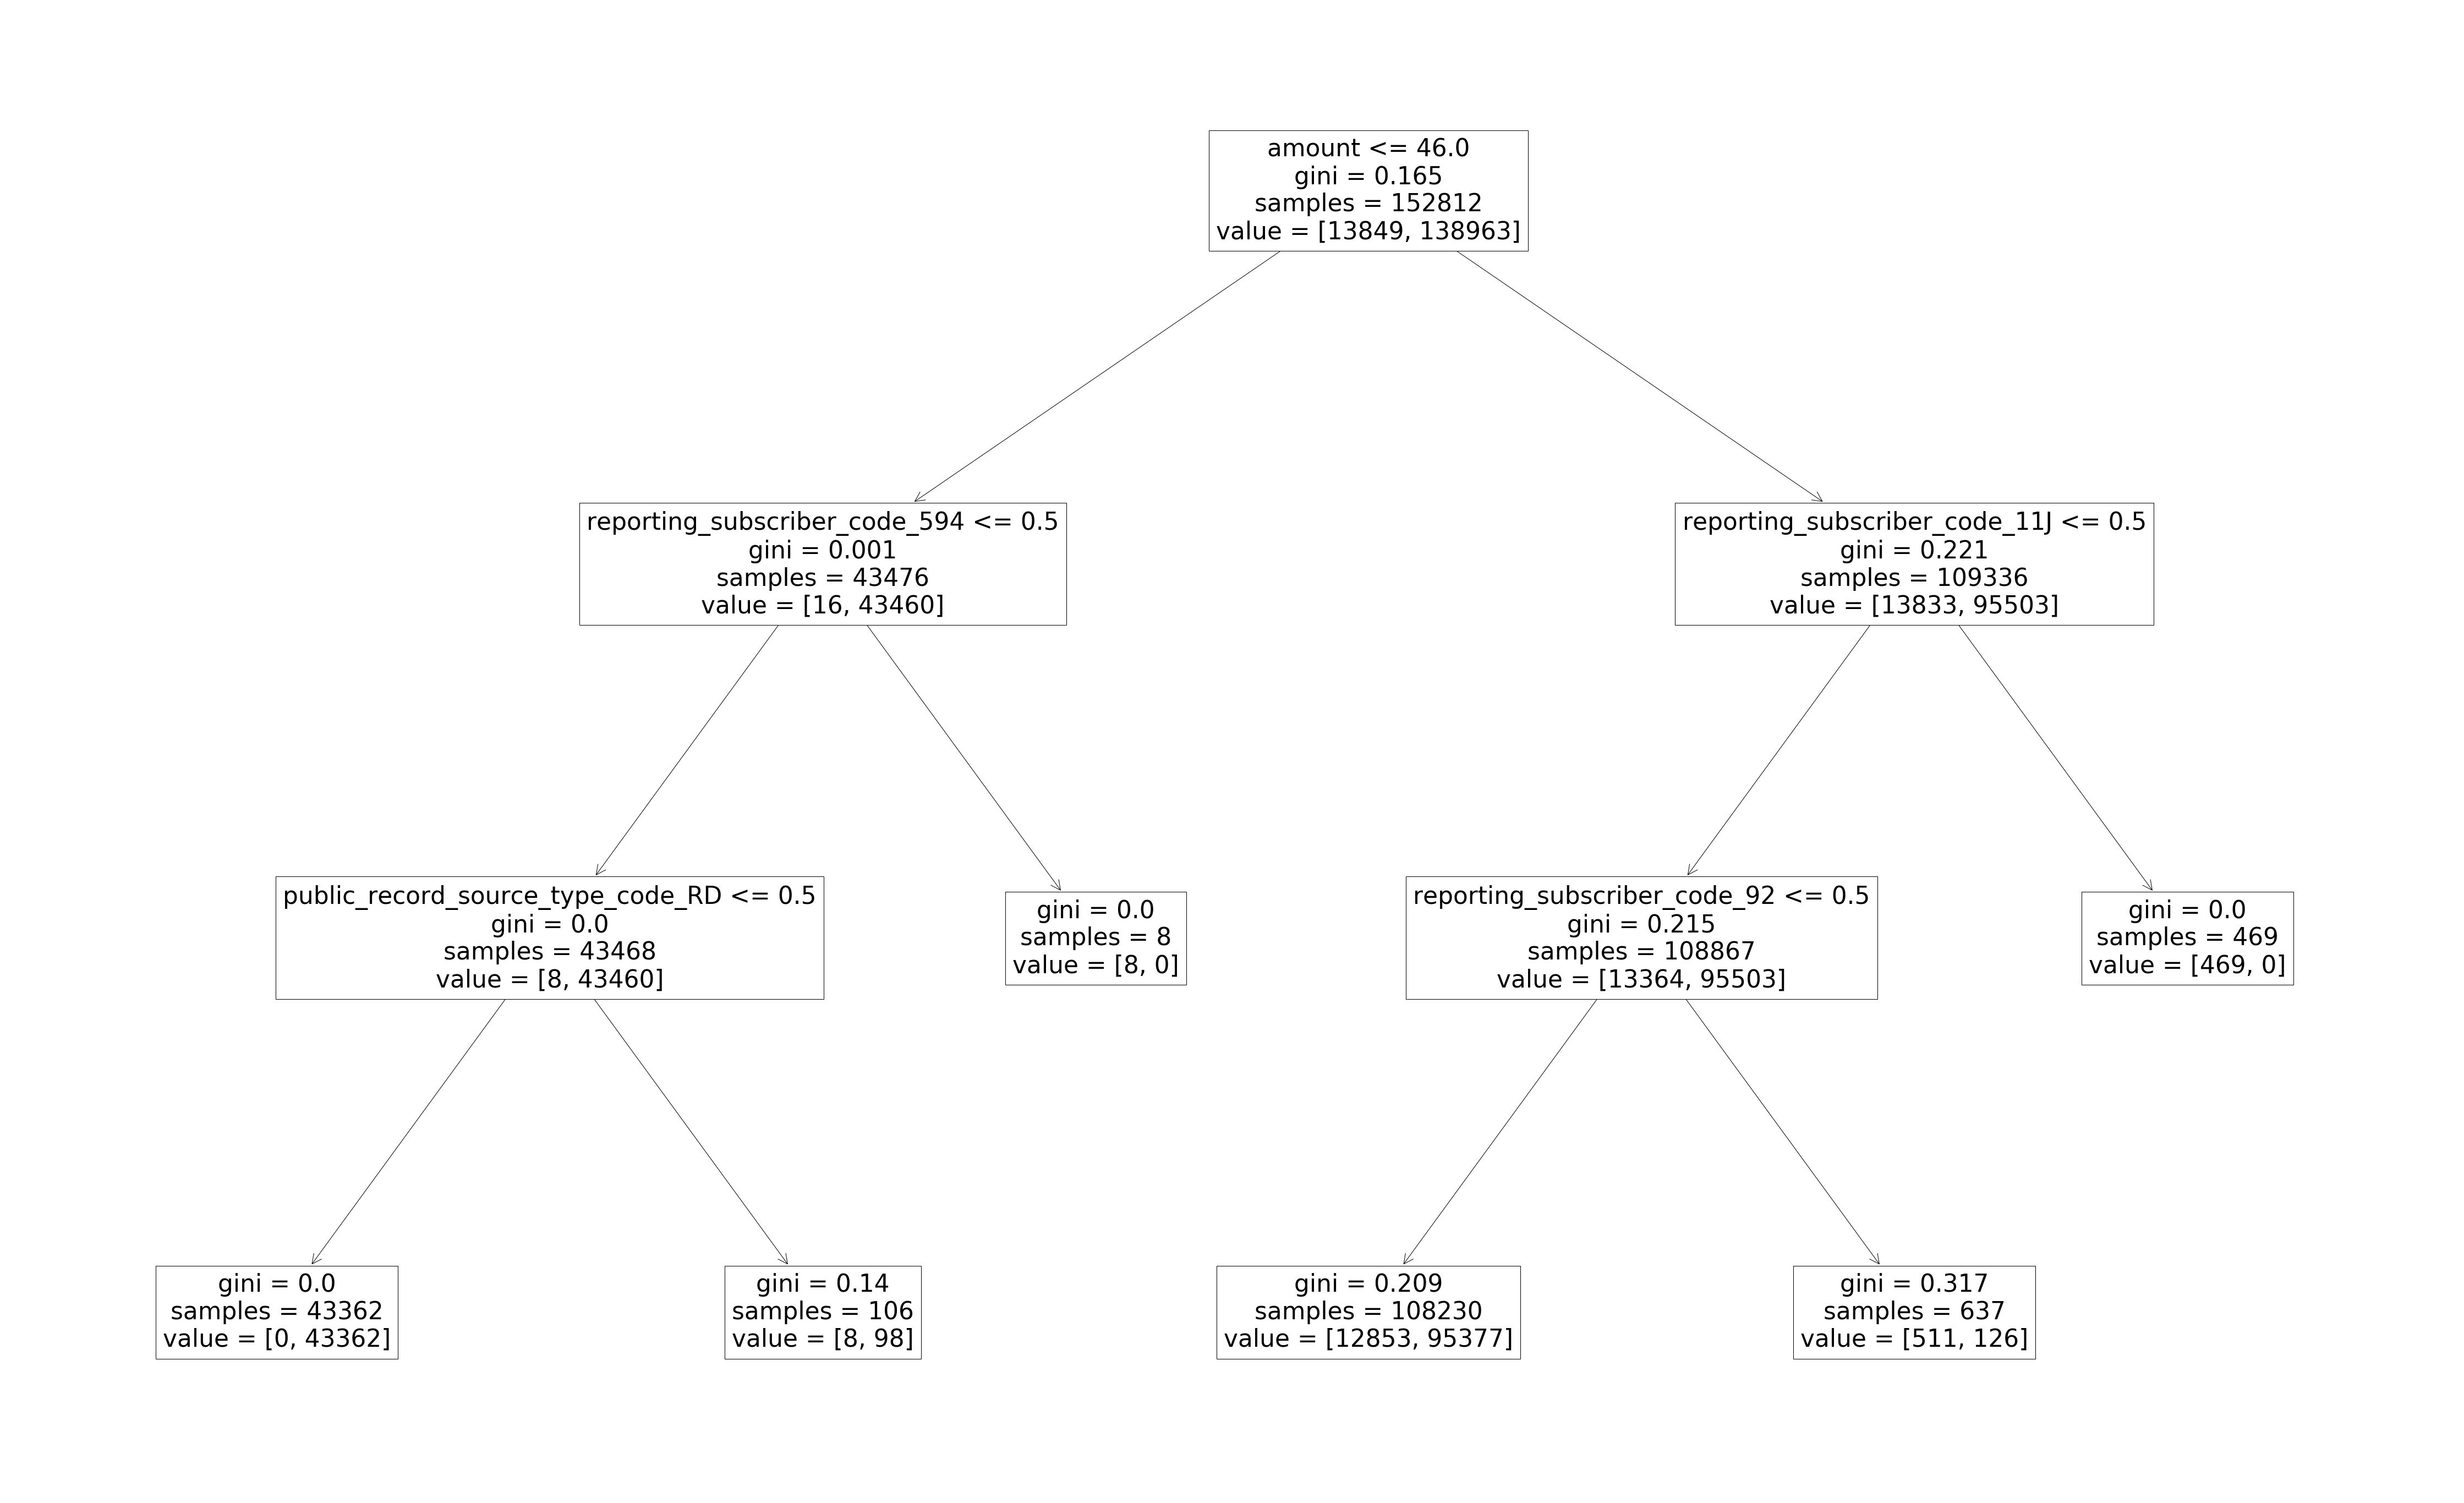

In [51]:
rcParams['figure.figsize'] = 80,50
plot_tree(m_list[0],feature_names=X_list[0]) 

[Text(2046.0, 2378.25, 'amount <= 27.0\ngini = 0.996\nsamples = 152812\nvalue = [1, 38, 5 ... 92, 1, 21]'),
 Text(1116.0, 1698.75, 'public_record_source_type_code_CI <= 0.5\ngini = 0.983\nsamples = 43475\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(744.0, 1019.25, 'diff_effe_paid_int <= 1.5\ngini = 0.983\nsamples = 43034\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(372.0, 339.75, 'gini = 0.982\nsamples = 29743\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(1116.0, 339.75, 'gini = 0.979\nsamples = 13291\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(1488.0, 1019.25, 'gini = 0.0\nsamples = 441\nvalue = [0, 0, 0 ... 0, 0, 0]'),
 Text(2976.0, 1698.75, 'public_record_source_type_code_RD <= 0.5\ngini = 0.997\nsamples = 109337\nvalue = [1, 38, 5 ... 92, 1, 21]'),
 Text(2232.0, 1019.25, 'public_record_type_code_bin_CP <= 0.5\ngini = 0.996\nsamples = 71135\nvalue = [1, 7, 4 ... 26, 1, 1]'),
 Text(1860.0, 339.75, 'gini = 0.996\nsamples = 70964\nvalue = [1, 7, 4 ... 26, 1, 1]'),
 Text(2604.0, 339.75, 'gini = 0.0\nsample

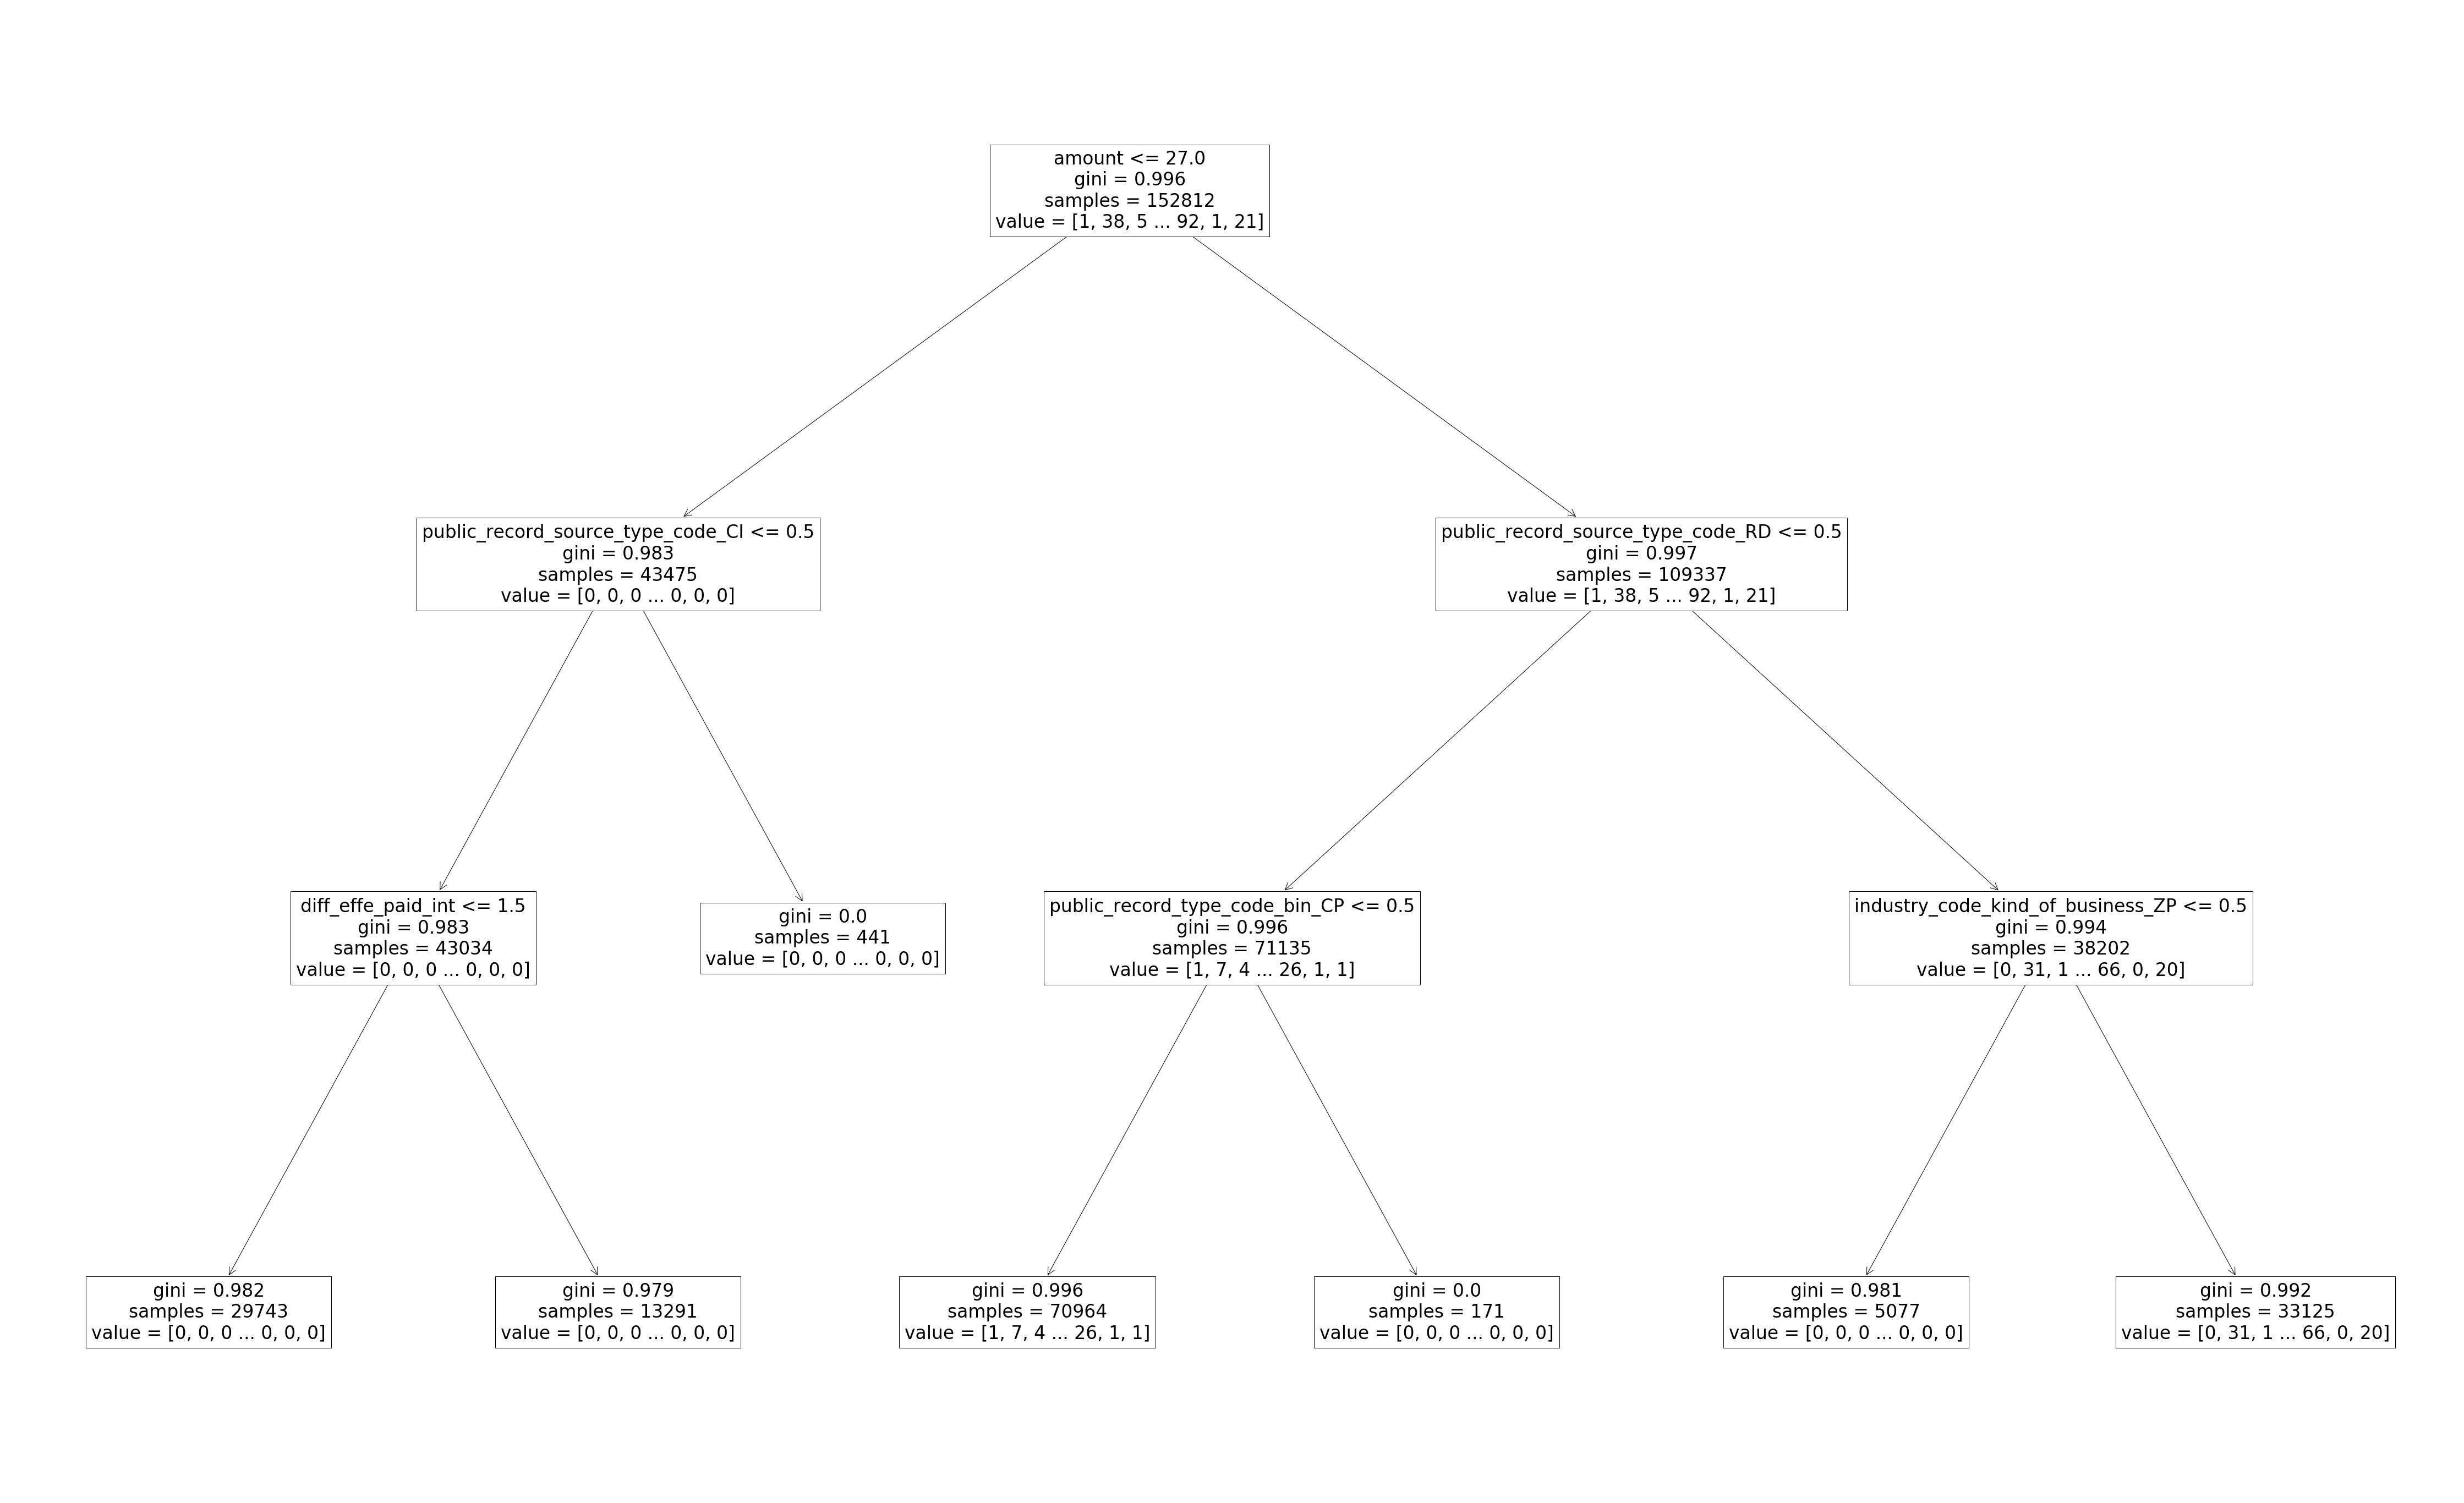

In [52]:
rcParams['figure.figsize'] = 80,50
plot_tree(m_list[1],feature_names=X_list[1]) 

[Text(2232.0, 2378.25, 'diff_paid_filed_int <= 51896.0\ngini = 0.83\nsamples = 152812\nvalue = [3024, 1557, 2420, 765, 359, 34775, 7199, 43080, 213\n4586, 21295, 2519, 4356, 14039, 11349, 1252, 24]'),
 Text(1116.0, 1698.75, 'amount <= 25.0\ngini = 0.761\nsamples = 90411\nvalue = [3024, 1, 2418, 765, 7, 34774, 7180, 7, 0, 3, 21295\n2519, 4356, 14039, 6, 0, 17]'),
 Text(558.0, 1019.25, 'diff_paid_filed_int <= 303.5\ngini = 0.287\nsamples = 41440\nvalue = [3024, 1, 2418, 765, 7, 34774, 0, 0, 0, 0, 399, 0\n2, 33, 0, 0, 17]'),
 Text(279.0, 339.75, 'gini = 0.132\nsamples = 35529\nvalue = [1562, 0, 12, 690, 7, 33052, 0, 0, 0, 0, 189, 0\n2, 12, 0, 0, 3]'),
 Text(837.0, 339.75, 'gini = 0.687\nsamples = 5911\nvalue = [1462, 1, 2406, 75, 0, 1722, 0, 0, 0, 0, 210, 0\n0, 21, 0, 0, 14]'),
 Text(1674.0, 1019.25, 'public_record_source_type_code_RD <= 0.5\ngini = 0.704\nsamples = 48971\nvalue = [0, 0, 0, 0, 0, 0, 7180, 7, 0, 3, 20896, 2519\n4354, 14006, 6, 0, 0]'),
 Text(1395.0, 339.75, 'gini = 0.394\n

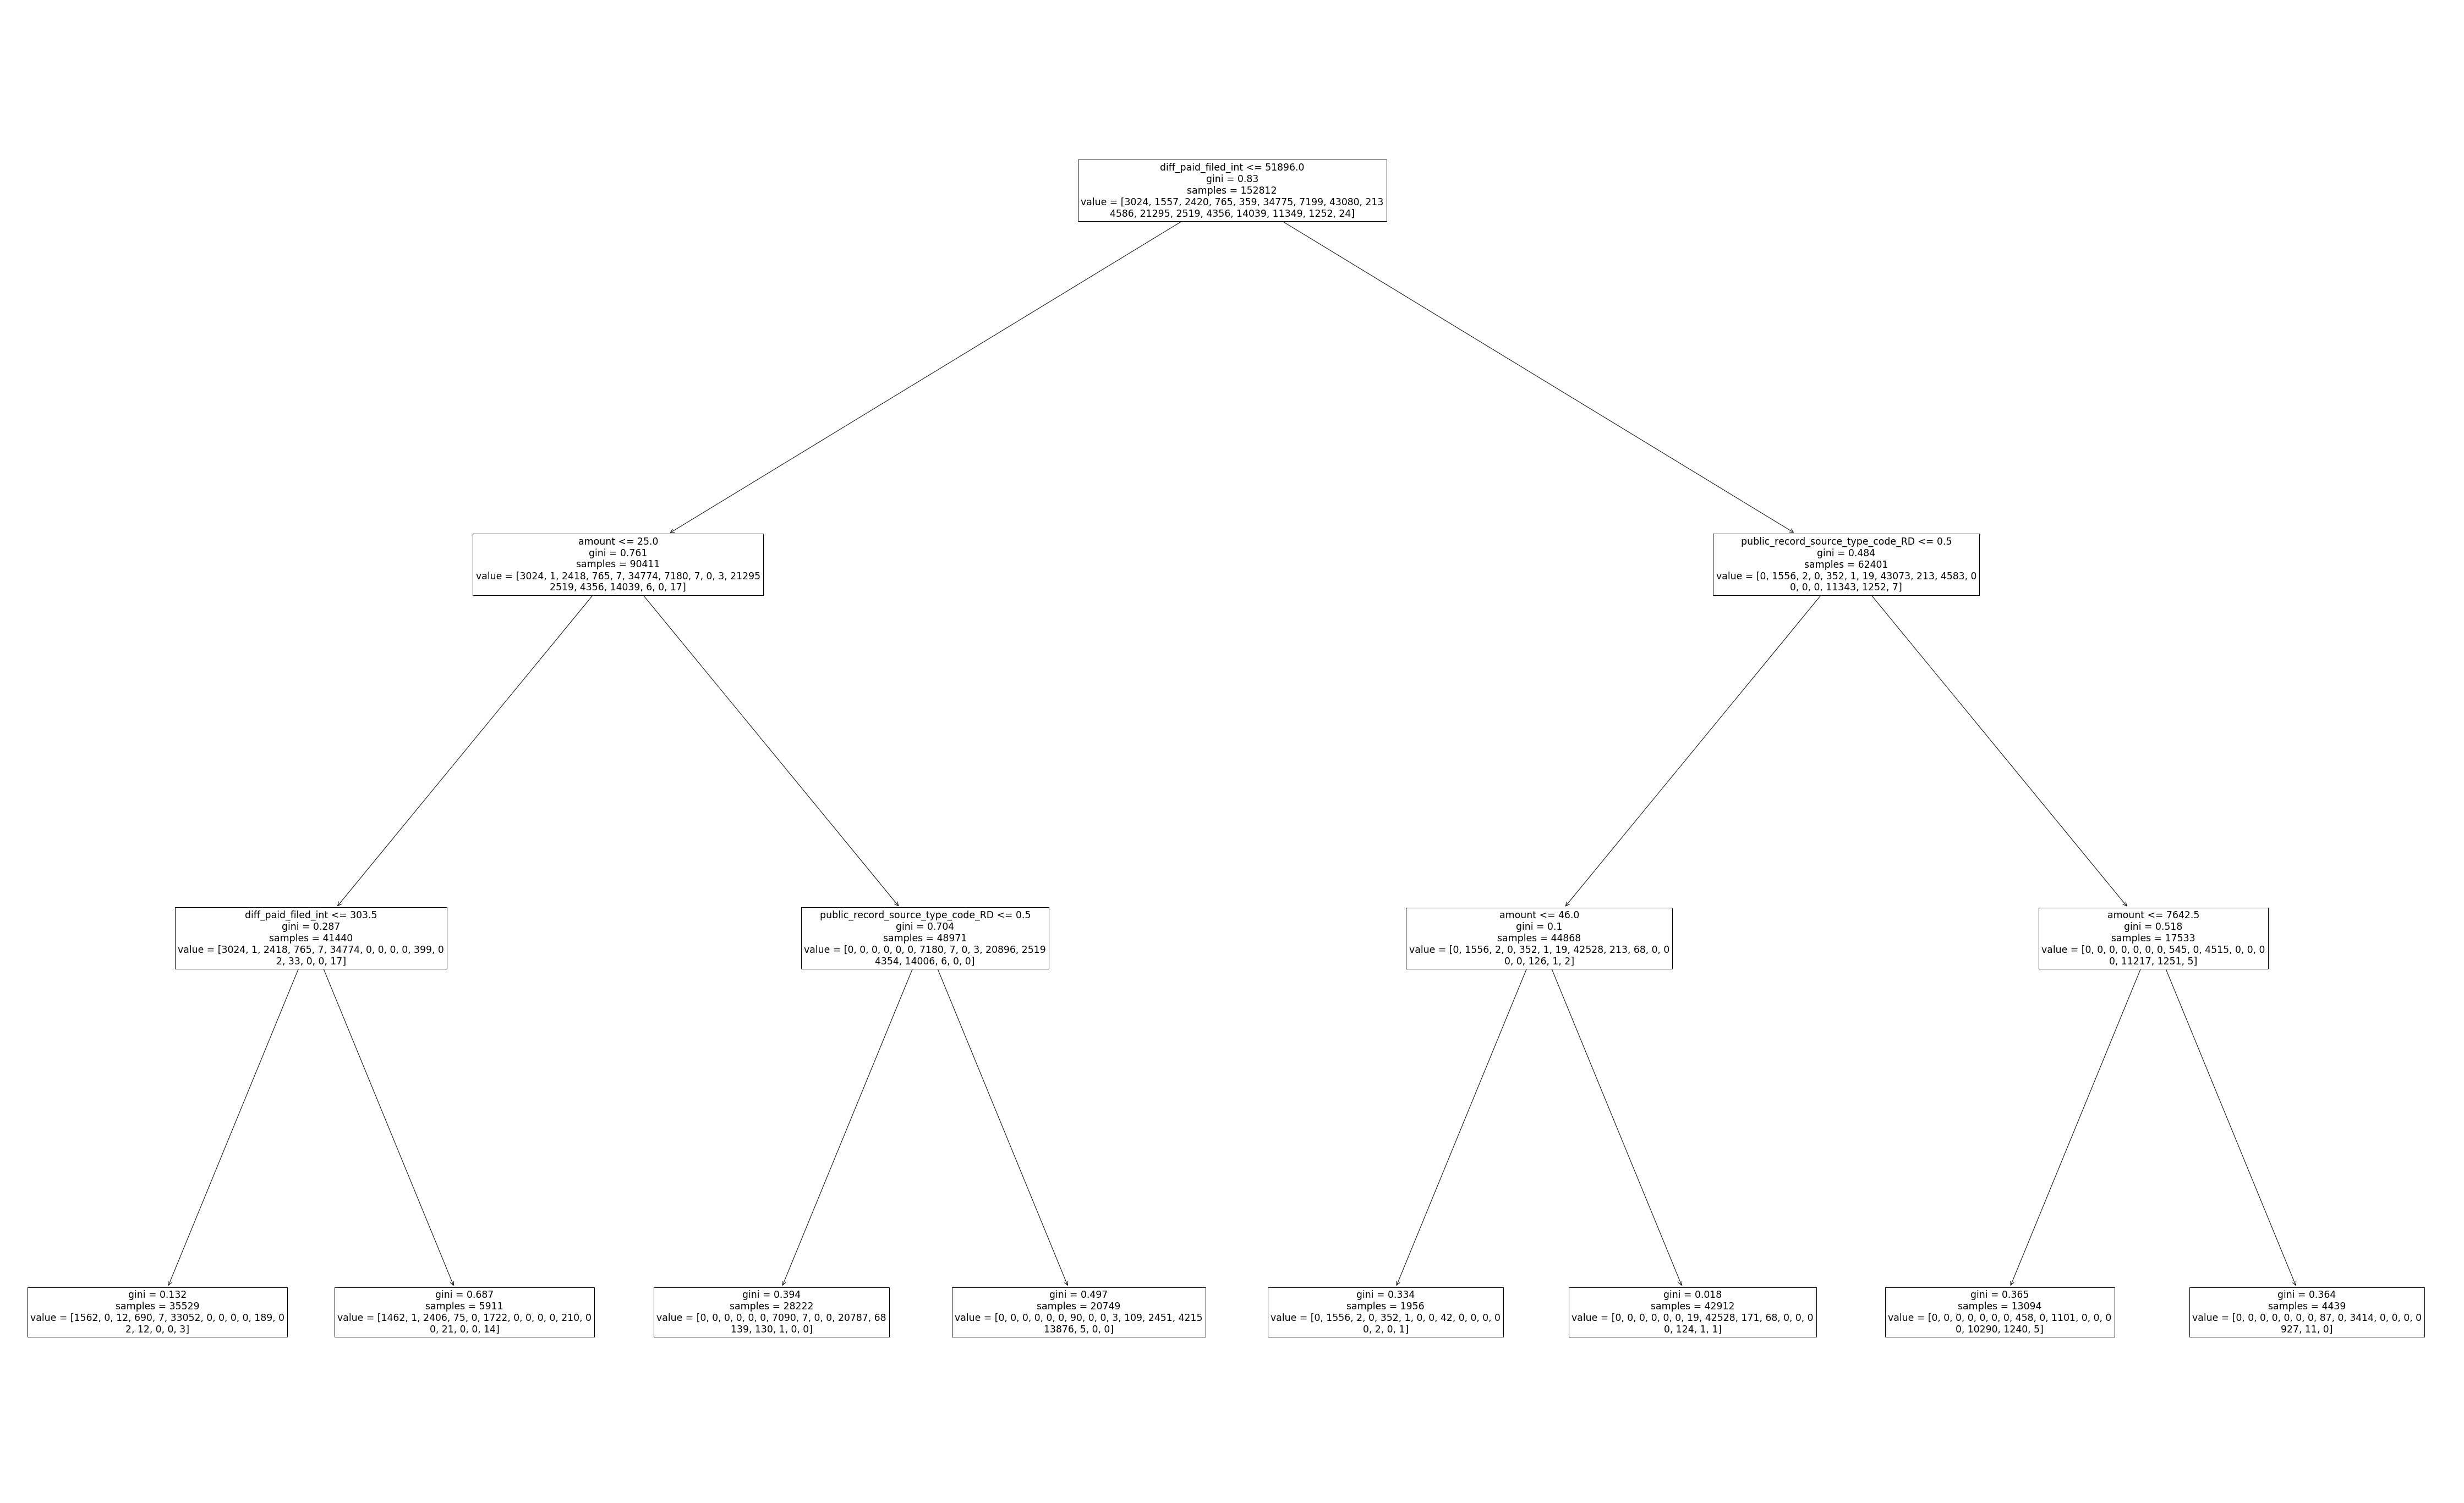

In [53]:
rcParams['figure.figsize'] = 80,50
plot_tree(m_list[2],feature_names=X_list[2]) 

[Text(2232.0, 2378.25, 'amount <= 6.0\ngini = 0.665\nsamples = 152811\nvalue = [1815, 2, 143, 68193, 17, 1, 4, 140, 36, 7, 101\n41244, 34, 27, 2275, 1, 38324, 109, 338]'),
 Text(1116.0, 1698.75, 'diff_effe_paid_int <= 13.5\ngini = 0.104\nsamples = 43613\nvalue = [1815, 2, 1, 442, 0, 0, 0, 0, 1, 0, 0, 41244, 0\n0, 0, 0, 108, 0, 0]'),
 Text(558.0, 1019.25, 'diff_effe_paid_int <= 0.5\ngini = 0.018\nsamples = 39029\nvalue = [246, 0, 0, 109, 0, 0, 0, 0, 0, 0, 0, 38669, 0\n0, 0, 0, 5, 0, 0]'),
 Text(279.0, 339.75, 'gini = 0.127\nsamples = 237\nvalue = [221, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0\n0, 0, 0, 0, 0]'),
 Text(837.0, 339.75, 'gini = 0.007\nsamples = 38792\nvalue = [25, 0, 0, 107, 0, 0, 0, 0, 0, 0, 0, 38655, 0\n0, 0, 0, 5, 0, 0]'),
 Text(1674.0, 1019.25, 'diff_paid_filed_int <= 51152.0\ngini = 0.562\nsamples = 4584\nvalue = [1569, 2, 1, 333, 0, 0, 0, 0, 1, 0, 0, 2575, 0\n0, 0, 0, 103, 0, 0]'),
 Text(1395.0, 339.75, 'gini = 0.561\nsamples = 2631\nvalue = [1539, 2, 0, 296, 0, 0, 0, 0,

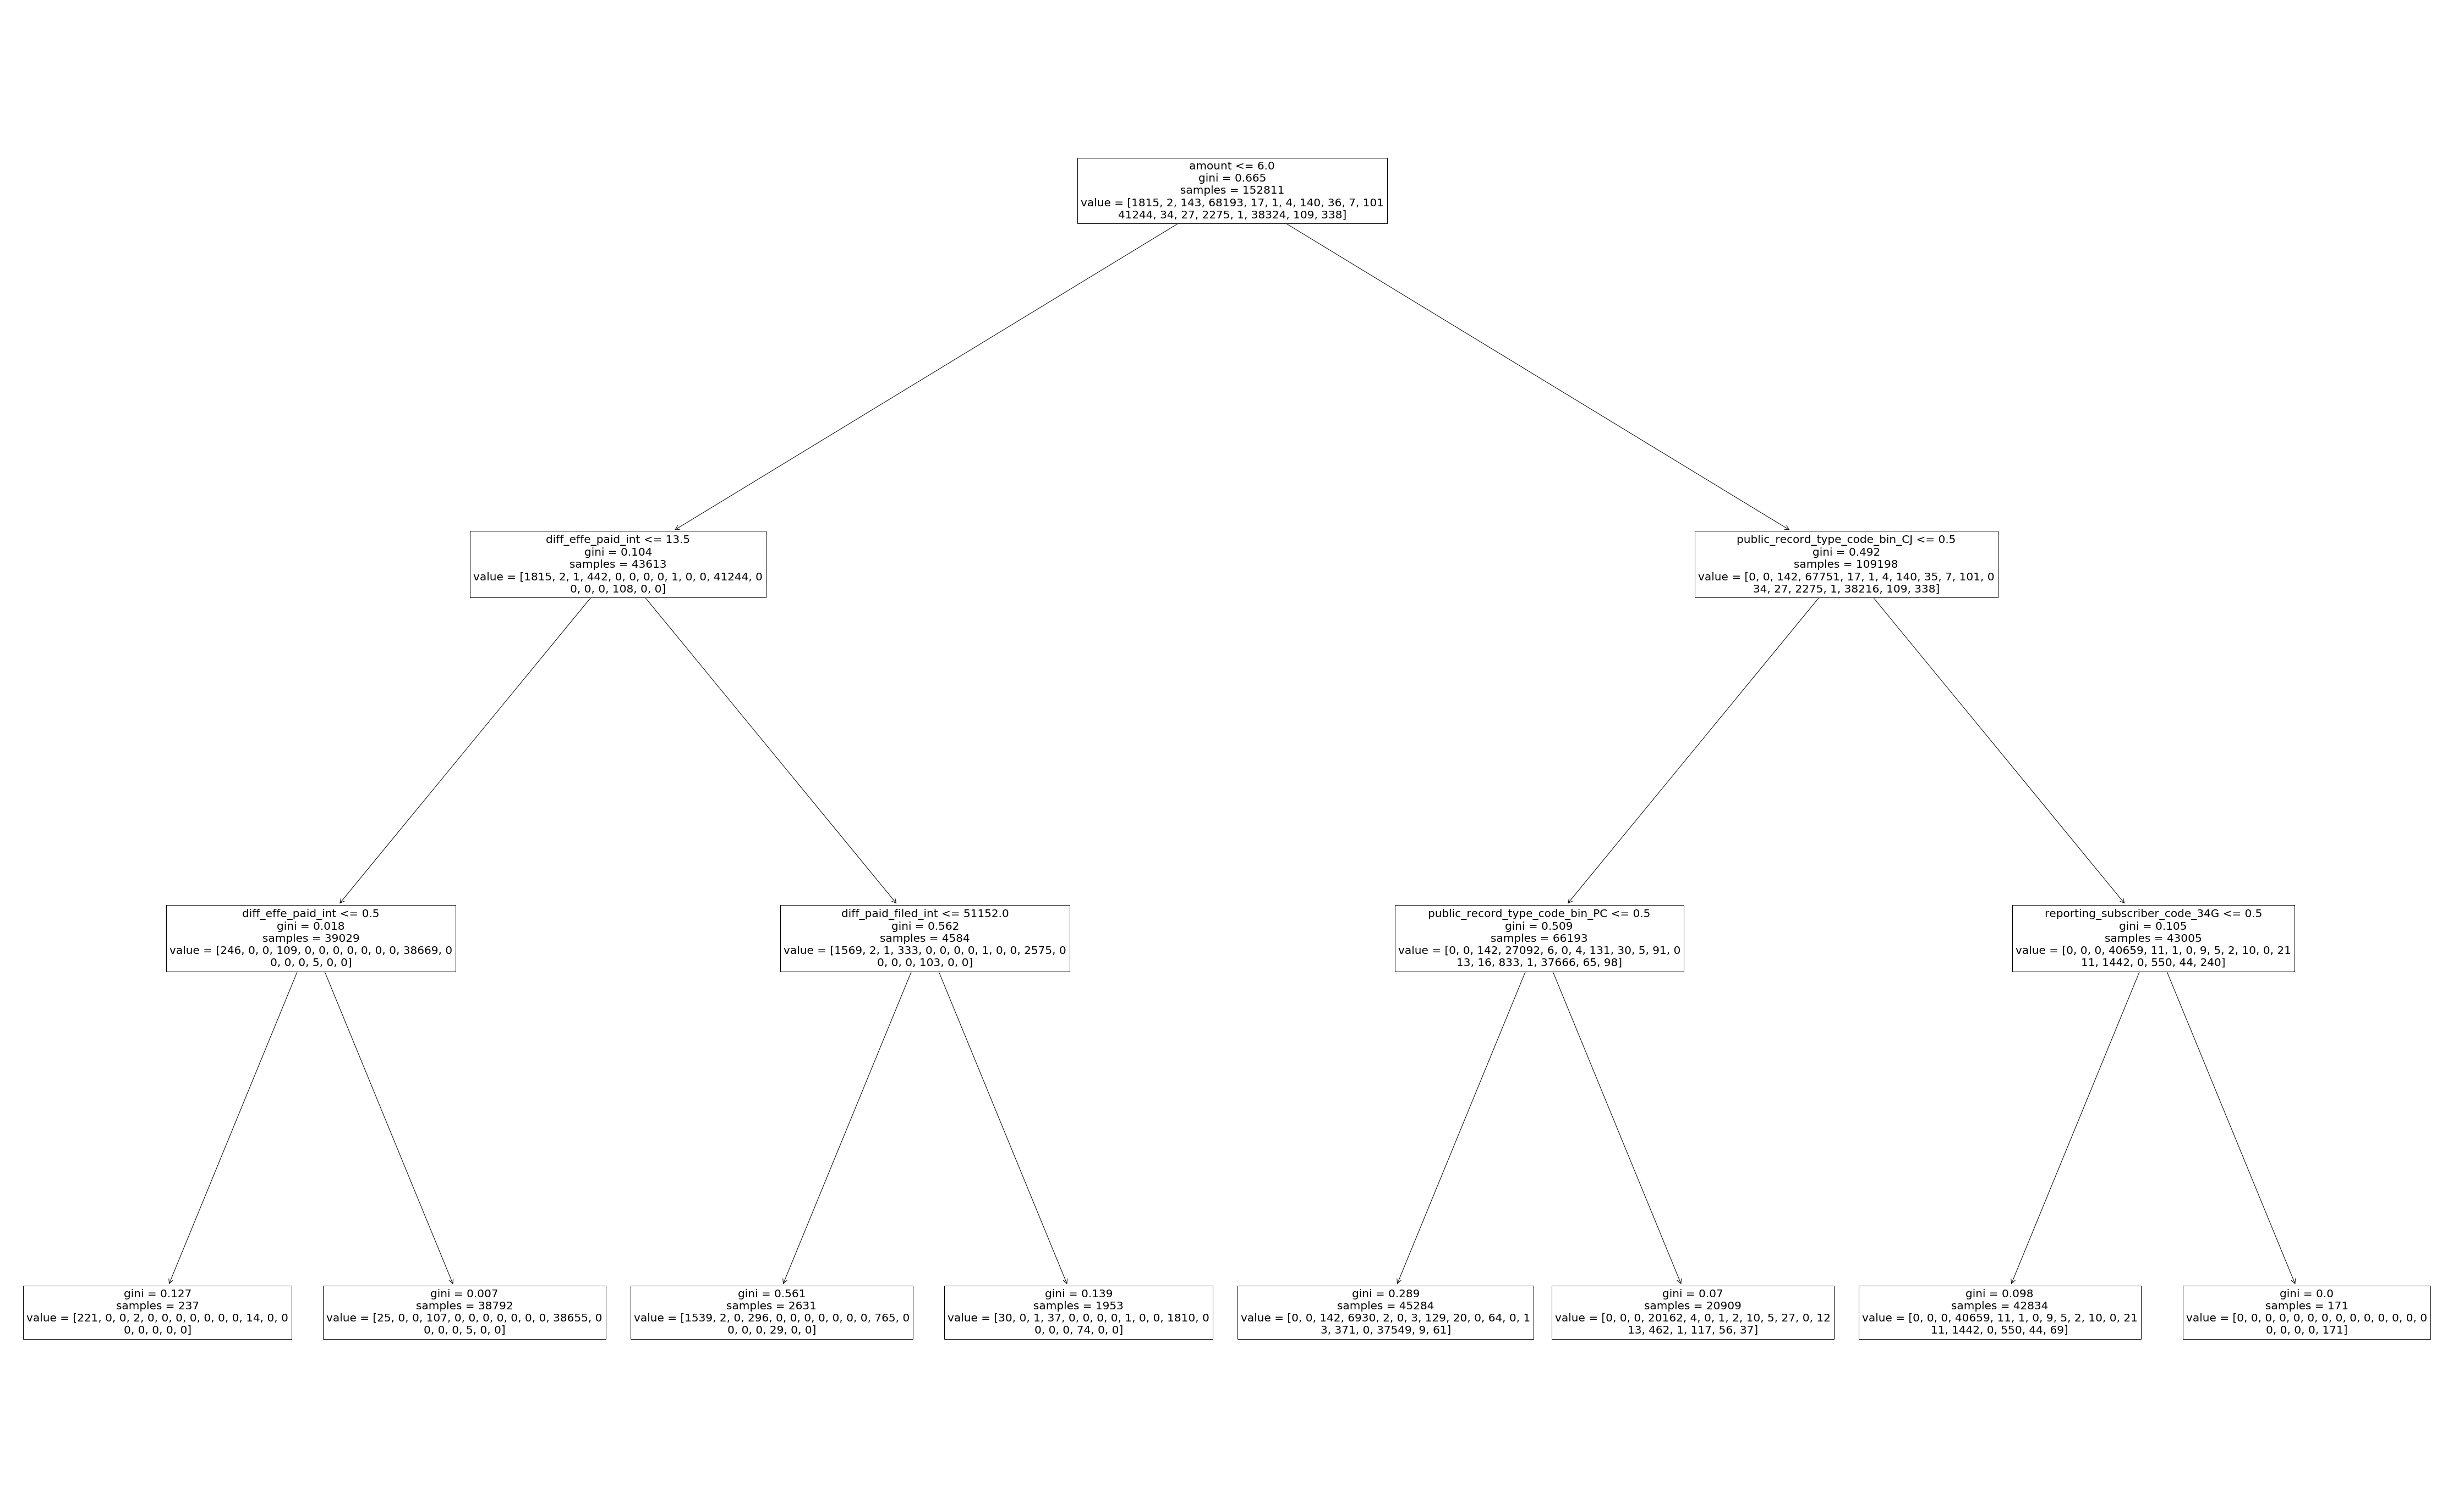

In [54]:
rcParams['figure.figsize'] = 80,50
plot_tree(m_list[3],feature_names=X_list[3]) 

[Text(2232.0, 2378.25, 'public_record_source_type_code_CI <= 0.5\ngini = 0.407\nsamples = 152812\nvalue = [43496, 109316]'),
 Text(1116.0, 1698.75, 'public_record_source_type_code_FE <= 0.5\ngini = 0.463\nsamples = 84547\nvalue = [30776, 53771]'),
 Text(558.0, 1019.25, 'reporting_subscriber_code_974 <= 0.5\ngini = 0.426\nsamples = 43409\nvalue = [13344, 30065]'),
 Text(279.0, 339.75, 'gini = 0.434\nsamples = 41839\nvalue = [13343, 28496]'),
 Text(837.0, 339.75, 'gini = 0.001\nsamples = 1570\nvalue = [1, 1569]'),
 Text(1674.0, 1019.25, 'reporting_subscriber_code_203 <= 0.5\ngini = 0.488\nsamples = 41138\nvalue = [17432, 23706]'),
 Text(1395.0, 339.75, 'gini = 0.49\nsamples = 39494\nvalue = [16985, 22509]'),
 Text(1953.0, 339.75, 'gini = 0.396\nsamples = 1644\nvalue = [447, 1197]'),
 Text(3348.0, 1698.75, 'industry_code_kind_of_business_ZP <= 0.5\ngini = 0.303\nsamples = 68265\nvalue = [12720, 55545]'),
 Text(2790.0, 1019.25, 'legislative_prohibited_code_2 <= 0.5\ngini = 0.383\nsamples =

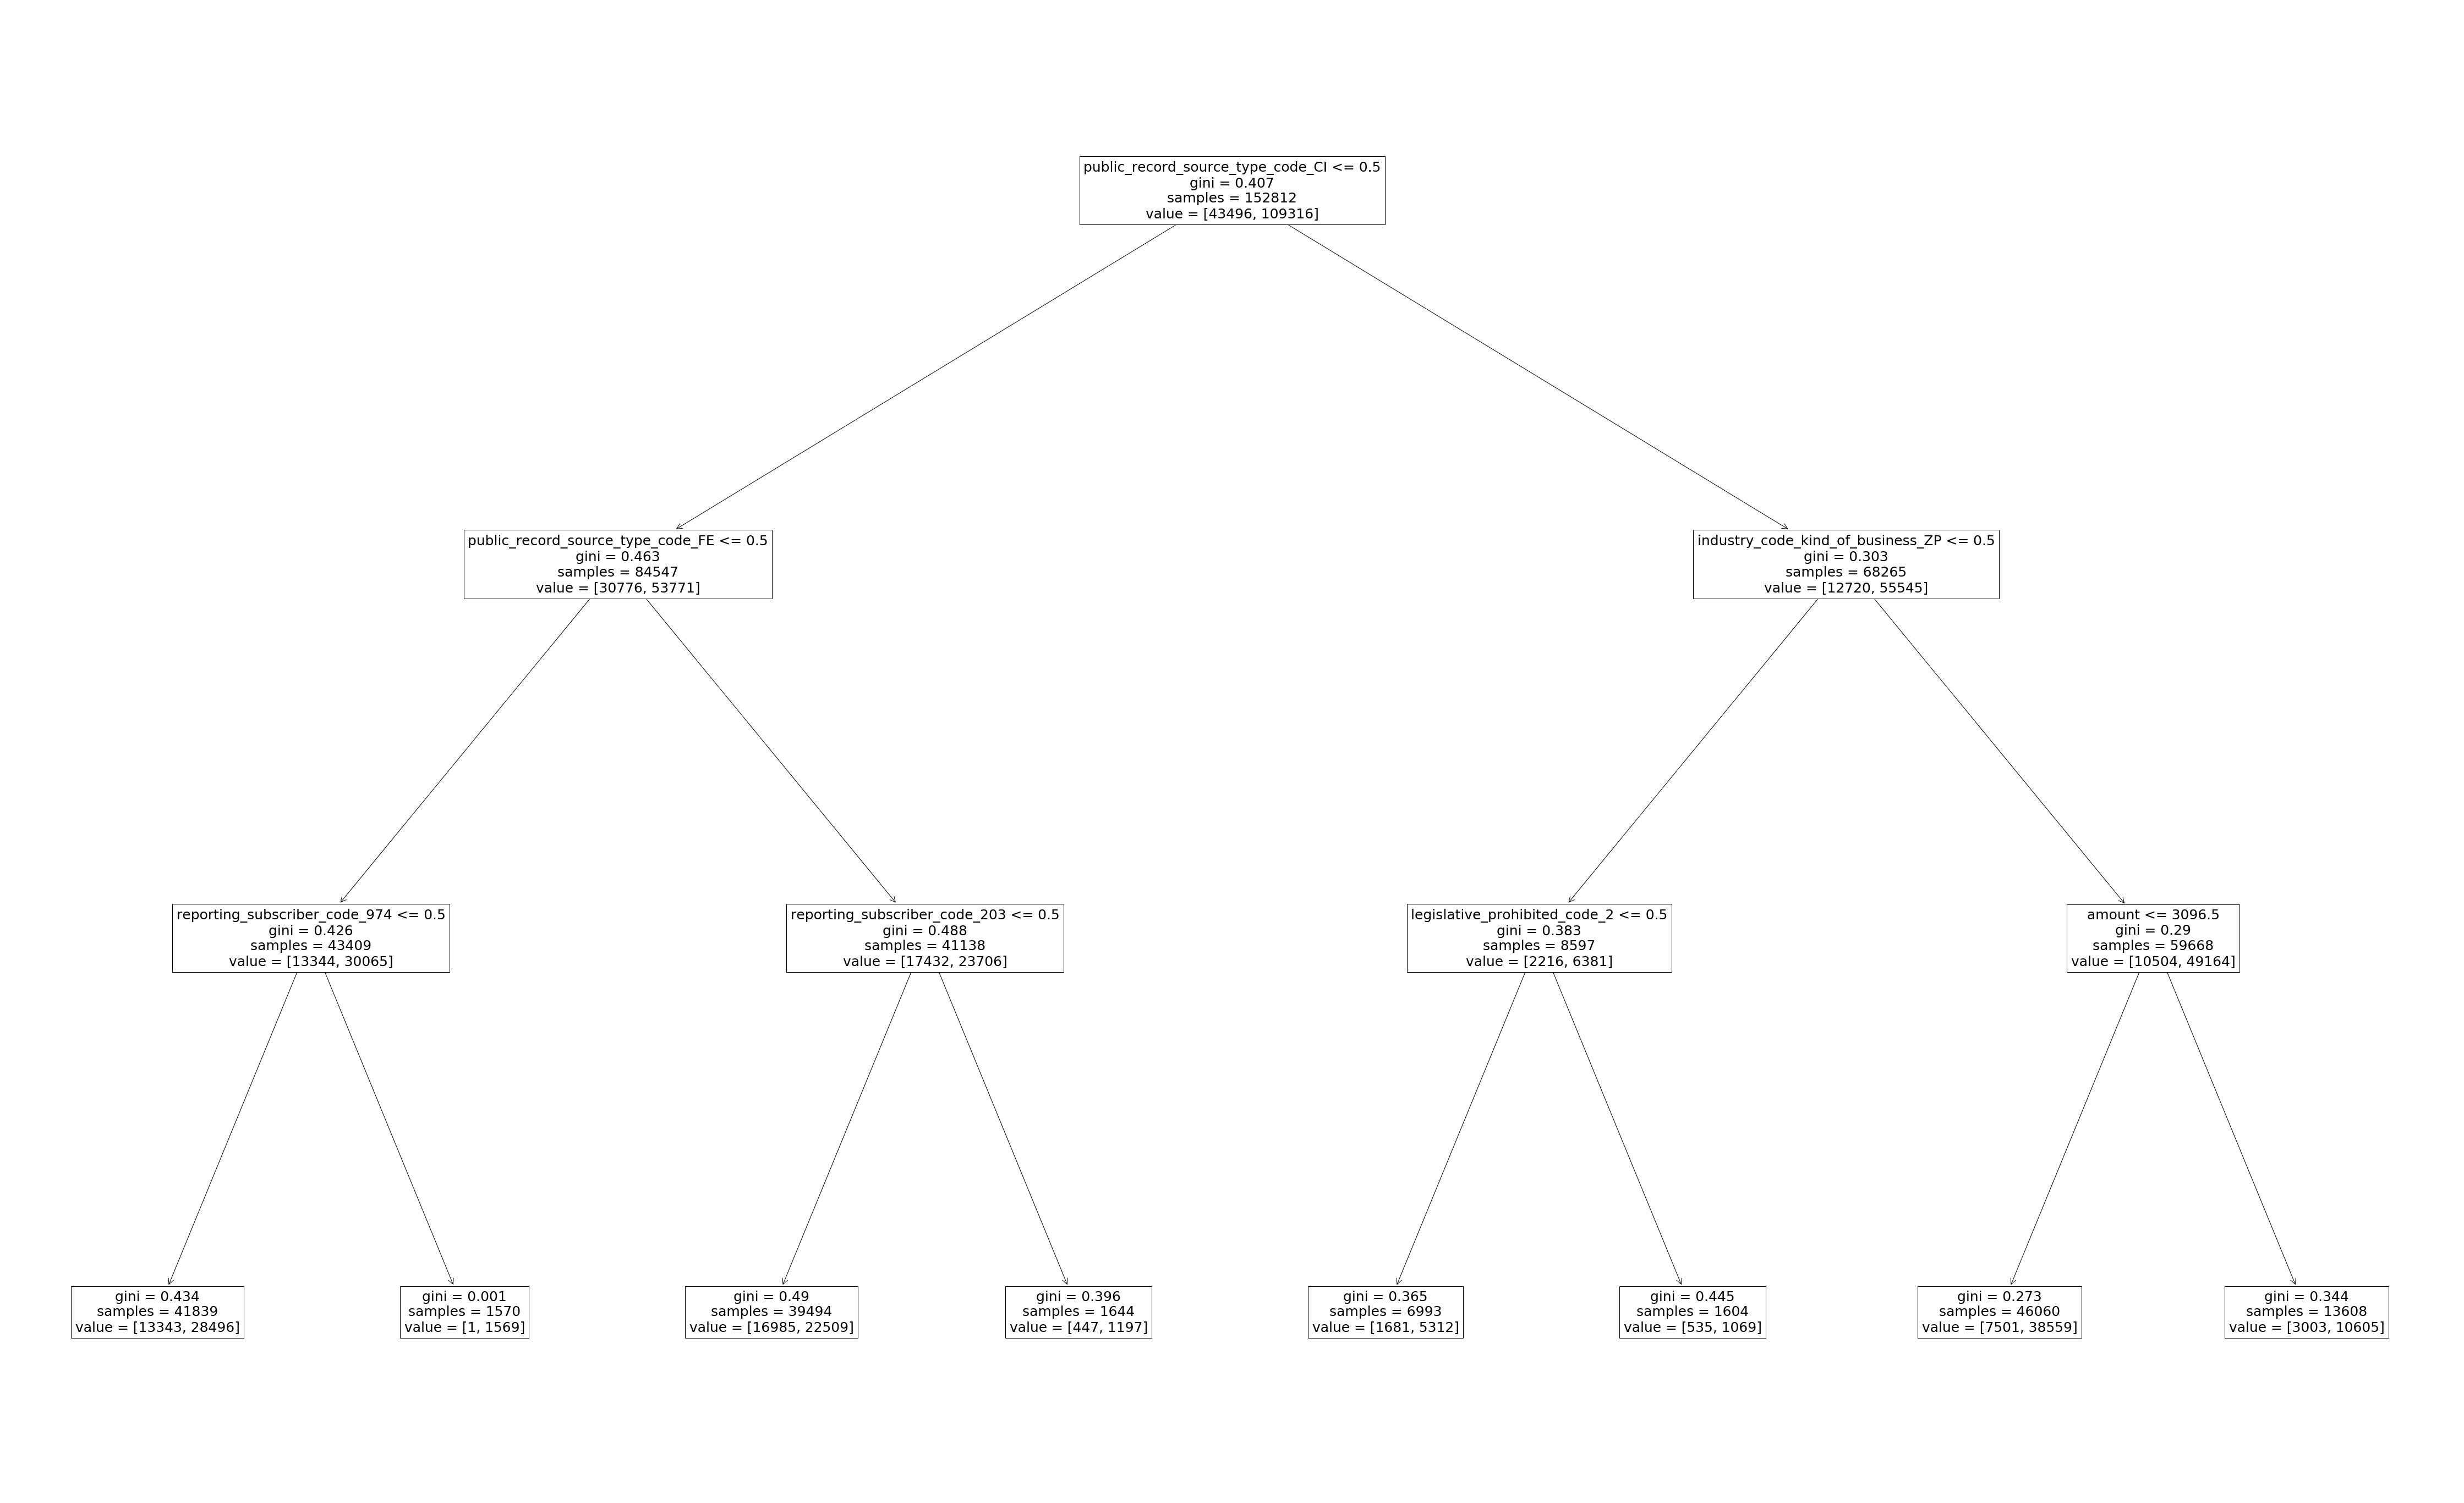

In [55]:
rcParams['figure.figsize'] = 80,50
plot_tree(m_list[4],feature_names=X_list[4]) 

[Text(2232.0, 2378.25, 'public_record_source_type_code_CI <= 0.5\ngini = 0.131\nsamples = 152812\nvalue = [142039, 10773]'),
 Text(1116.0, 1698.75, 'reporting_subscriber_code_205 <= 0.5\ngini = 0.004\nsamples = 84547\nvalue = [84375, 172]'),
 Text(558.0, 1019.25, 'public_record_type_code_bin_PC <= 0.5\ngini = 0.003\nsamples = 84476\nvalue = [84330, 146]'),
 Text(279.0, 339.75, 'gini = 0.002\nsamples = 83737\nvalue = [83648, 89]'),
 Text(837.0, 339.75, 'gini = 0.142\nsamples = 739\nvalue = [682, 57]'),
 Text(1674.0, 1019.25, 'public_record_type_code_bin_CJ <= 0.5\ngini = 0.464\nsamples = 71\nvalue = [45, 26]'),
 Text(1395.0, 339.75, 'gini = 0.229\nsamples = 38\nvalue = [33, 5]'),
 Text(1953.0, 339.75, 'gini = 0.463\nsamples = 33\nvalue = [12, 21]'),
 Text(3348.0, 1698.75, 'amount <= 973.5\ngini = 0.262\nsamples = 68265\nvalue = [57664, 10601]'),
 Text(2790.0, 1019.25, 'reporting_subscriber_code_44 <= 0.5\ngini = 0.332\nsamples = 25225\nvalue = [19918, 5307]'),
 Text(2511.0, 339.75, 'gin

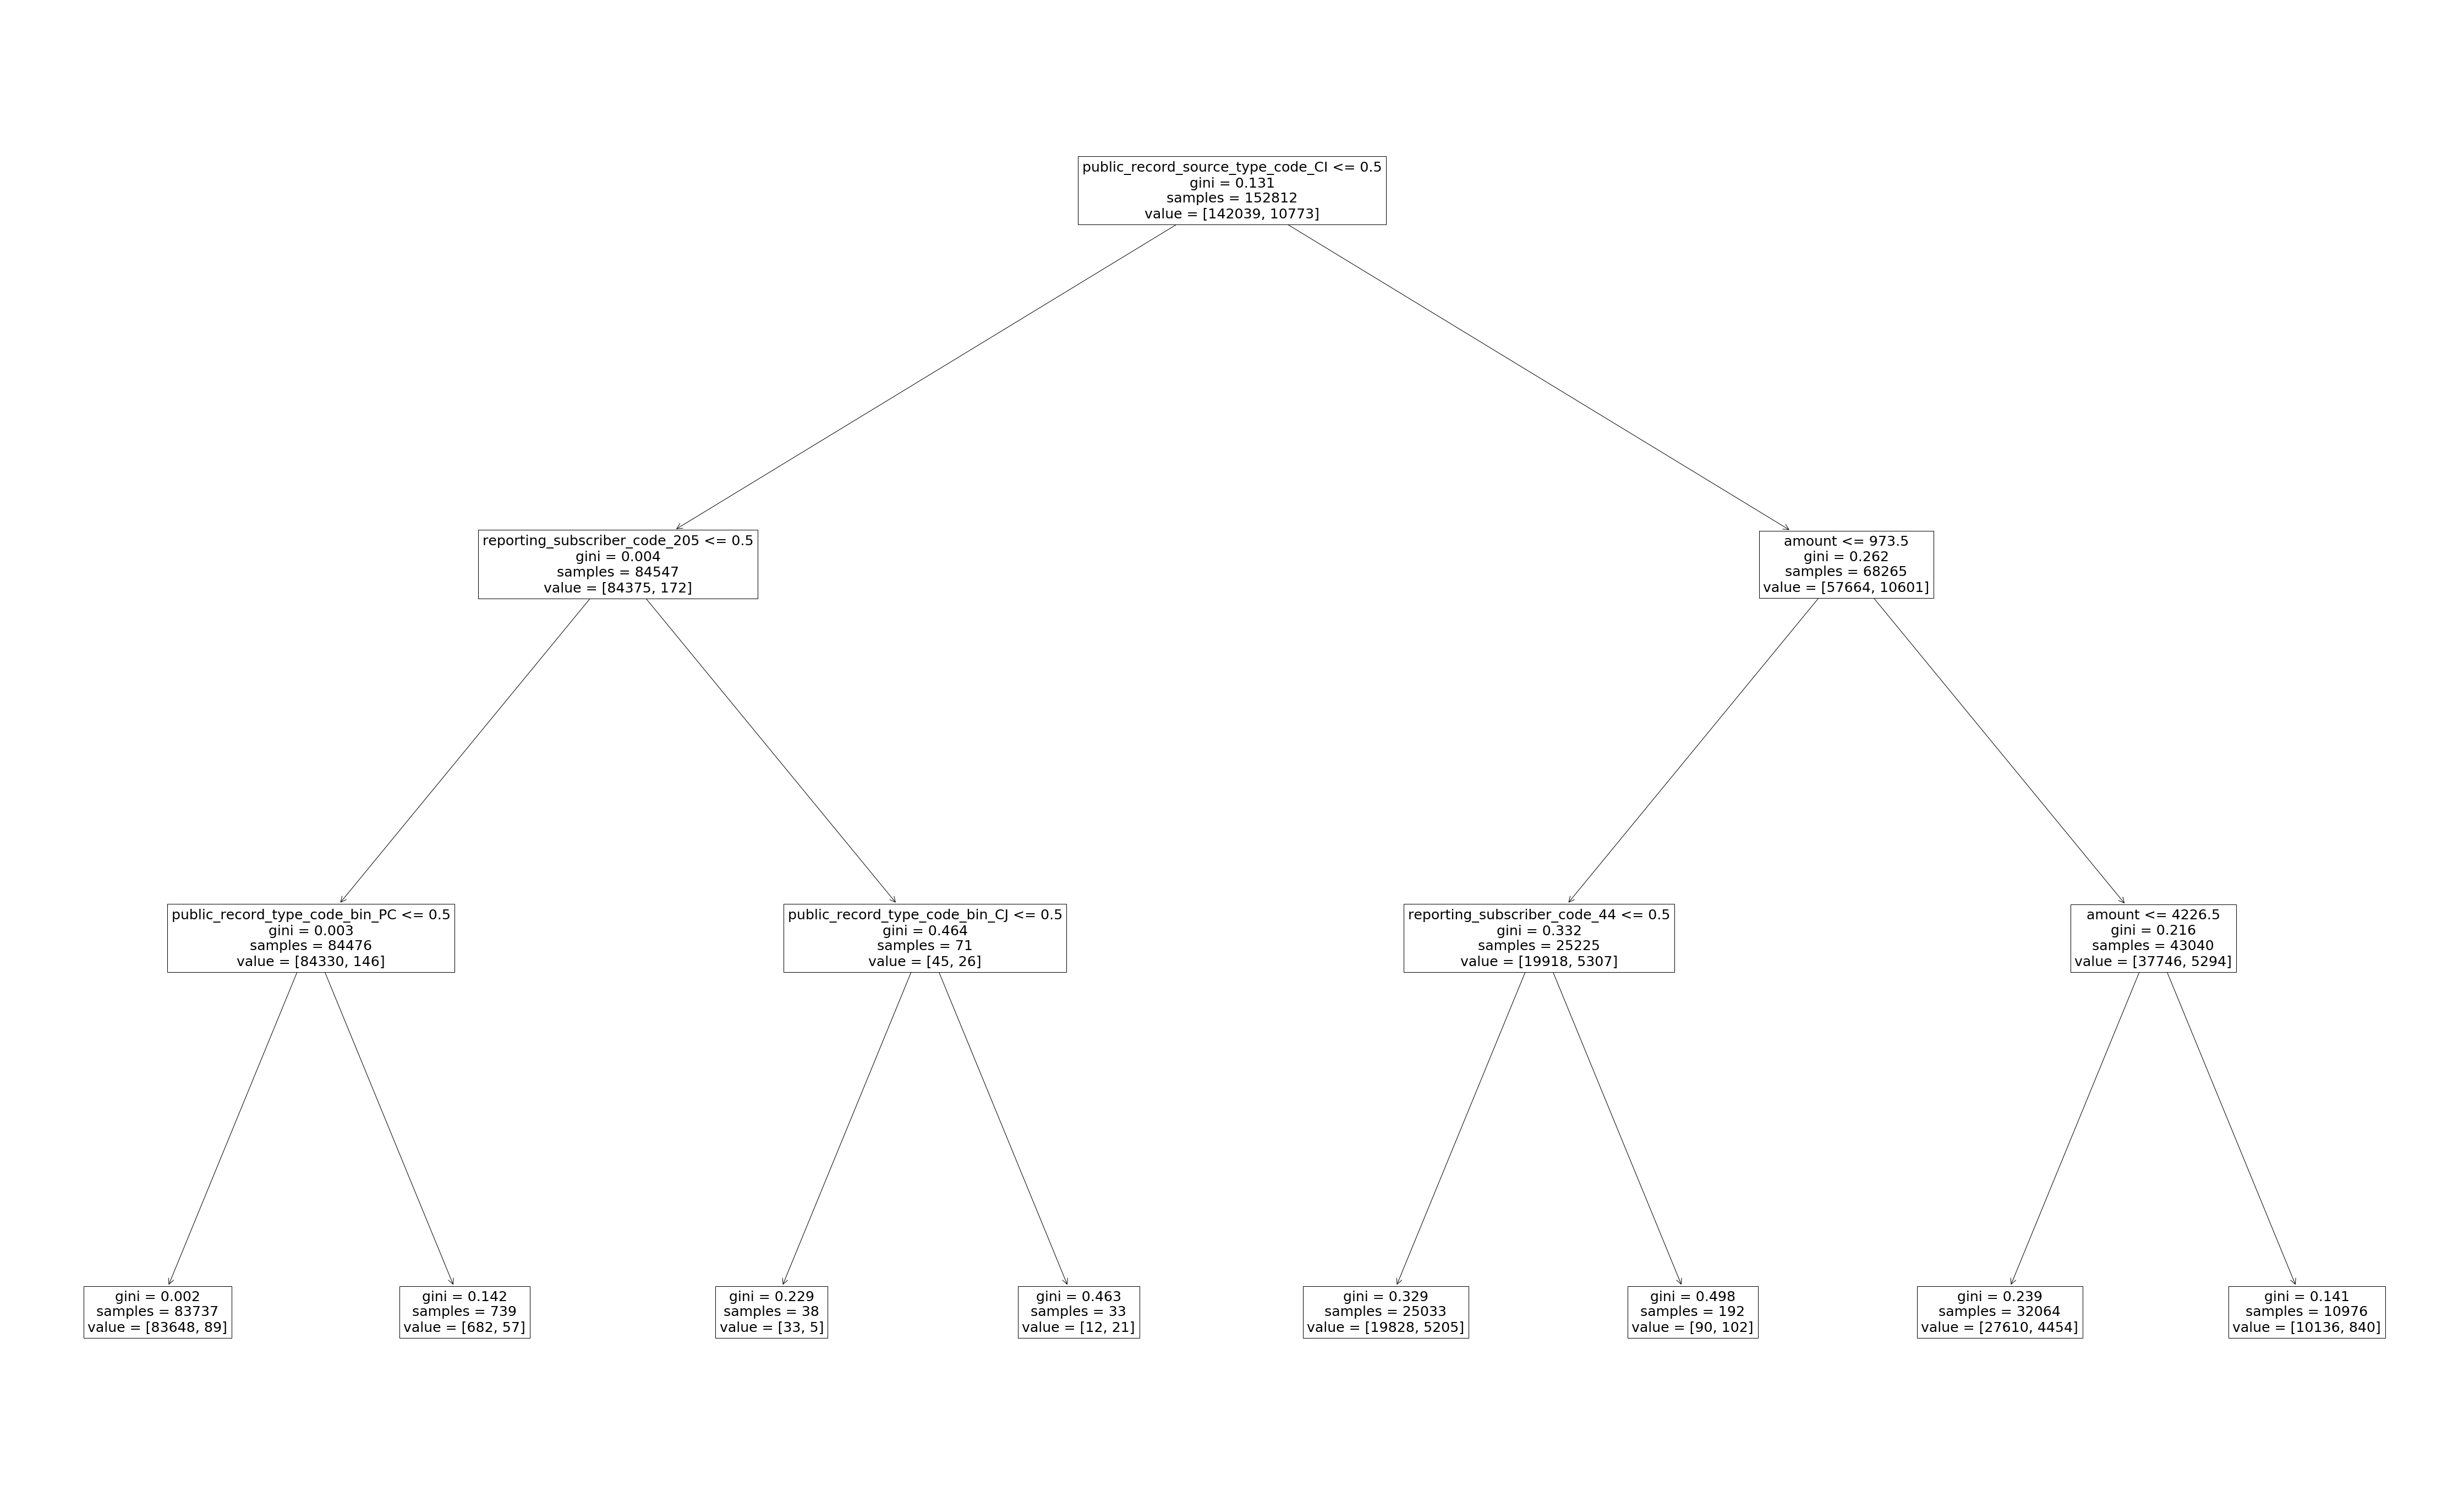

In [56]:
rcParams['figure.figsize'] = 80,50
plot_tree(m_list[5],feature_names=X_list[5]) 

#### Hypothesis 3: The segmentation of Loans among the filed/ paid/ effective loans.

#### Hypothesis 4: The relationship beween the segmentations of Loans and amount.

#### Hypothesis X: By clustering the data, is there other trend/pattern?